In [289]:
from ACAgraphML.Dataset import ZINC_Dataset
from ACAgraphML.Transforms import OneHotEncodeFeat, BagOfPathsTransform, SteadyStateTransform
import torch_geometric.transforms as T
from torch.nn.functional import one_hot
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import os

sns.set_theme()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [290]:
NUM_NODE_FEATS = 28
NUM_EDGE_FEATS = 4
EVALUATIONS = {}

# Setup

In [291]:
def plotTrueVsPred(y, y_pred, y_val, y_val_pred, title='True vs Predicted Values'):
    plt.figure(figsize=(8, 5))
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, alpha=0.5)
    plt.scatter(y, y_pred, alpha=0.5, s=2, label='Train Predictions', color='orange')
    plt.scatter(y_val, y_val_pred, alpha=0.5, s=2, label='Validation Predictions', color='blue')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(title)
    plt.xlim(-10, 5)
    plt.ylim(-10, 5)
    plt.legend()
    plt.show()
    

In [292]:
#LASSO regression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def evaluateLASSO(X_train, y_train, X_val, y_val, alpha=0.1):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    
    y_pred = lasso.predict(X_train)
    y_val_pred = lasso.predict(X_val)

    mse = mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    mae = mean_absolute_error(y_train, y_pred)

    mse_val = mean_squared_error(y_val, y_val_pred)
    r2_val = r2_score(y_val, y_val_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)

    print(f'LASSO Regression (alpha={alpha}):')
    print(f'Train MSE: {mse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}')
    print(f'Validation MSE: {mse_val:.4f}, R2: {r2_val:.4f}, MAE: {mae_val:.4f}')
    plotTrueVsPred(y_train, y_pred, y_val, y_val_pred, title=f'LASSO Regression (alpha={alpha})')
    return mae_val


In [293]:
#Random forest
from sklearn.ensemble import RandomForestRegressor


def evaluateRF(x, y, x_val, y_val):
    rf = RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1, verbose=1)
    rf.fit(x, y)
    y_pred = rf.predict(x)
    y_val_pred = rf.predict(x_val)
    
    #Evaluate the model
    mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    print(f"Mean Absolute Error: {mae}")

    plotTrueVsPred(y, y_pred, y_val, y_val_pred, title='Random Forest: True vs Predicted Values')
    return mae

In [294]:
#xgboost
from xgboost import XGBRegressor

def evaluateXGB(x, y, x_val, y_val):
    xgb = XGBRegressor(n_estimators=1000, random_state=42, n_jobs=-1, objective="reg:absoluteerror")
    xgb.fit(x, y)
    y_pred = xgb.predict(x)
    y_val_pred = xgb.predict(x_val)
    
    #Evaluate the model
    mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    print(f"Mean Absolute Error: {mae}")

    plotTrueVsPred(y, y_pred, y_val, y_val_pred, title='XGBoost: True vs Predicted Values')

    return mae

In [295]:
#SVR
from sklearn.svm import SVR
def evaluateSVR(x, y, x_val, y_val):
    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr.fit(x, y)
    y_pred = svr.predict(x)
    y_val_pred = svr.predict(x_val)
    
    #Evaluate the model
    mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    print(f"Mean Absolute Error: {mae}")

    plotTrueVsPred(y, y_pred, y_val, y_val_pred, title='SVR: True vs Predicted Values')

    return mae

In [296]:
def saveEvaluations(evaluations, filename='evaluations.json'):
    with open(filename, 'w') as f:
        json.dump(evaluations, f, indent=4)
        
def loadEvaluations(filename='evaluations.json'):
    import json
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            return json.load(f)

def completeEvaluations(name, evaluations, x, y, x_val, y_val):
    print(f"Evaluating {name}...")
    result = {'#Feats': x.shape[1]}

    mae_lasso = evaluateLASSO(x, y, x_val, y_val, alpha=0.1)
    result['LASSO'] = mae_lasso
    evaluations[name] = result
    saveEvaluations(evaluations)

    mae_rf = evaluateRF(x, y, x_val, y_val)
    result['RF'] = mae_rf
    evaluations[name] = result
    saveEvaluations(evaluations)

    mae_xgb = evaluateXGB(x, y, x_val, y_val)
    result['XGB'] = mae_xgb
    evaluations[name] = result
    saveEvaluations(evaluations)

    mae_svr = evaluateSVR(x, y, x_val, y_val)
    result['SVR'] = mae_svr
    evaluations[name] = result
    saveEvaluations(evaluations)
    
    print(f"{name} - RF MAE: {mae_rf}, XGB MAE: {mae_xgb}, SVR MAE: {mae_svr}")
    return result


In [297]:
def plotEvaluations(evaluations):
    # Collect all model keys (excluding '#Feats') from all results
    model_keys = set()
    for result in evaluations.values():
        model_keys.update([k for k in result.keys() if k != '#Feats'])

    model_keys = sorted(model_keys)
    names = []
    scores = {k: [] for k in model_keys}

    for name, result in evaluations.items():
        # Include all entries, fill missing model keys with 0
        label = name
        if '#Feats' in result:
            label += f"\n(#F:{result['#Feats']})"
        names.append(label)
        for k in model_keys:
            scores[k].append(result.get(k, 0))

    x = np.arange(len(names))
    width = 0.8 / len(model_keys) if model_keys else 0.2

    fig, ax = plt.subplots(figsize=(12, 6))
    for i, k in enumerate(model_keys):
        ax.bar(x + (i - len(model_keys)/2) * width + width/2, scores[k], width, label=k)

    ax.set_ylabel('Mean Absolute Error')
    ax.set_title('Model Performance by Feature Set')
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [298]:
#Correlation analysis
def featureTargetCorrelation(features, target, top_n=5):
    """
    Plot correlation coefficients of given features with the target value,
    and scatter plots for the top_n most correlated components.
    """
    corr_coeffs = np.array([
        np.corrcoef(features[:, i].numpy(), target.numpy())[0, 1]
        for i in range(features.shape[1])
    ])
    corr_coeffs = np.nan_to_num(corr_coeffs)
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(features.shape[1]), corr_coeffs, color='skyblue')
    plt.title('Correlation Coefficients of Feature with Target Value')
    plt.xlabel('Feature Index')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(range(0, features.shape[1]))
    plt.grid(axis='y')
    plt.show()
    
    top_indices = np.argsort(np.abs(corr_coeffs))[-top_n:][::-1]
    fig, axes = plt.subplots(1, top_n, figsize=(4 * top_n, 4))
    for i, idx in enumerate(top_indices):
        axes[i].scatter(features[:, idx].numpy(), target.numpy(), alpha=0.5, s=1)
        axes[i].set_title(f'Feat {idx} vs Target: {corr_coeffs[idx]:.2f}')
        axes[i].set_xlabel(f'Feature {idx}')
        axes[i].set_ylabel('Target Value')
        axes[i].grid(True)
    plt.tight_layout()
    plt.show()

    return corr_coeffs, top_indices

In [299]:
from sklearn.linear_model import Lasso
def LASSOfeatureSelection(features, target, features_val, target_val, alpha=0.1):
    """
    Perform LASSO feature selection and return the selected features.
    """
    lasso = Lasso(alpha=alpha)
    lasso.fit(features.numpy(), target.numpy())
    
    selected_features = np.where(lasso.coef_ != 0)[0]
    print(f"Selected Features: {selected_features}")

    y_pred = lasso.predict(features.numpy())
    y_val_pred = lasso.predict(features_val.numpy())

    #Evaluate the model
    mse = mean_squared_error(target_val.numpy(), y_val_pred)
    r2 = r2_score(target_val.numpy(), y_val_pred)
    mae = mean_absolute_error(target_val.numpy(), y_val_pred)
    print(f"LASSO Mean Squared Error: {mse}")
    print(f"LASSO R^2 Score: {r2}")
    print(f"LASSO Mean Absolute Error: {mae}")
    plotTrueVsPred(target.numpy(), y_pred, target_val.numpy(), y_val_pred, title='LASSO: True vs Predicted Values')

    #Plot the coefficients
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(lasso.coef_)), lasso.coef_, color='skyblue')
    plt.title('LASSO Coefficients')
    plt.xlabel('Feature Index')
    plt.ylabel('Coefficient Value')
    plt.axhline(0, color='red', linestyle='--')
    plt.xticks(range(0, len(lasso.coef_)))
    plt.grid(axis='y')
    plt.show()
    
    return selected_features, lasso.coef_

# Bag of Nodes

In [300]:
oneHotTransform = OneHotEncodeFeat(
    nClasses=NUM_NODE_FEATS,
)

trainDataset_bon = ZINC_Dataset.SMALL_TRAIN.load(transform=oneHotTransform)
valDataset_bon = ZINC_Dataset.SMALL_VAL.load(transform=oneHotTransform)
trainDataset_bon[0].x.shape

torch.Size([29, 28])

In [301]:
bon_train = [g.x.sum(dim=0) for g in trainDataset_bon]
bon_val = [g.x.sum(dim=0) for g in valDataset_bon]

bon_train = torch.stack(bon_train)
bon_val = torch.stack(bon_val)

## PCA

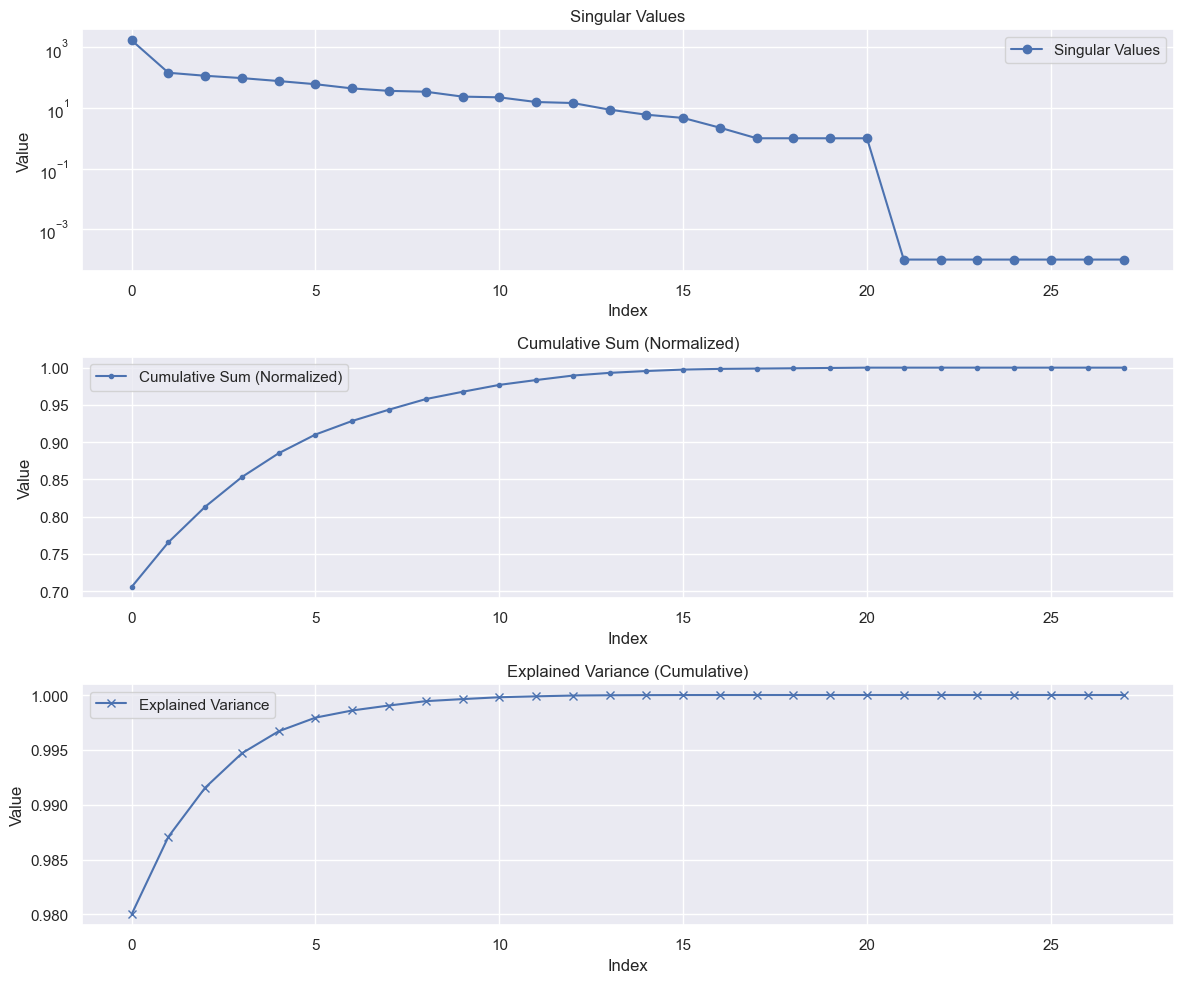

In [302]:
U, S, V = torch.linalg.svd(bon_train.float(), full_matrices=False)

fig, axes = plt.subplots(3, 1, figsize=(12, 10))

axes[0].semilogy(S, marker='o', label='Singular Values')
axes[0].set_title('Singular Values')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Value')
axes[0].legend()

cumsum_norm = torch.cumsum(S, dim=0) / torch.sum(S)
axes[1].plot(cumsum_norm.numpy(), marker='.', label='Cumulative Sum (Normalized)')
axes[1].set_title('Cumulative Sum (Normalized)')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Value')
axes[1].legend()

explained_variance = S**2 / torch.sum(S**2)
explained_variance_cumsum = torch.cumsum(explained_variance, dim=0)
axes[2].plot(explained_variance_cumsum.numpy(), marker='x', label='Explained Variance')
axes[2].set_title('Explained Variance (Cumulative)')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Value')
axes[2].legend()

plt.tight_layout()
plt.show()


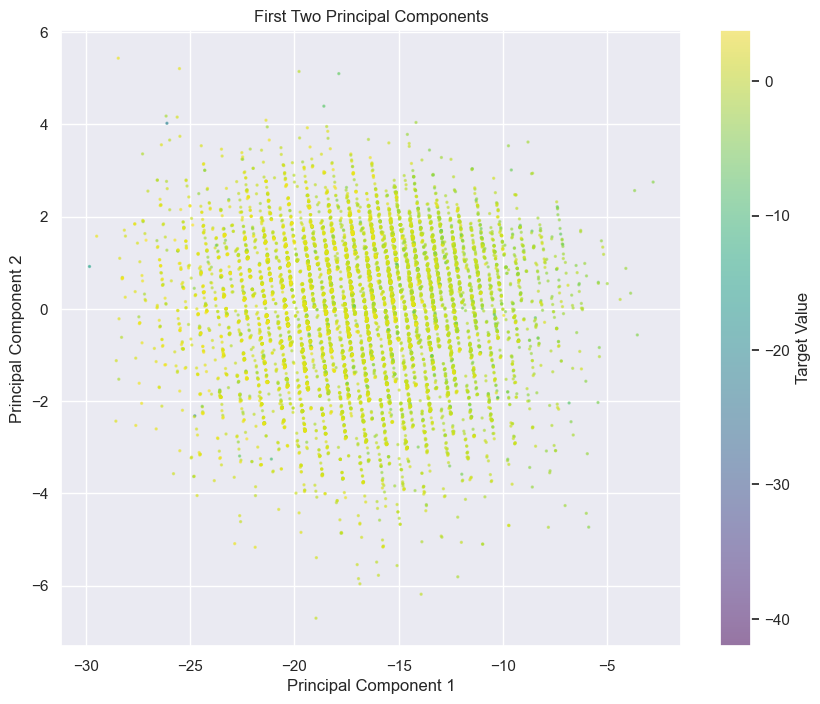

In [303]:
#Plot the first two principal components
Phi = bon_train.float() @ V.T
plt.figure(figsize=(10, 8))
plt.scatter(Phi[:, 0], Phi[:, 1], alpha=0.5, s=2, c=trainDataset_bon.y, cmap='viridis')
plt.title('First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Target Value')
plt.show()

In [304]:
#Plot the first 3 principal components using plotly
import plotly.express as px
fig = px.scatter_3d(
    Phi.numpy(),
    x=0, y=1, z=2,
    color=trainDataset_bon.y.numpy(),
    labels={'color': 'Target Value'},
    title='First Three Principal Components'
)

fig.update_traces(marker=dict(size=2))
fig.update_layout(
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    )
)
fig.show()

In [305]:
PrincipalComponents_bon = Phi
PrincipalComponents_bon_val = bon_val.float() @ V.T

c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning:

invalid value encountered in divide

c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning:

invalid value encountered in divide



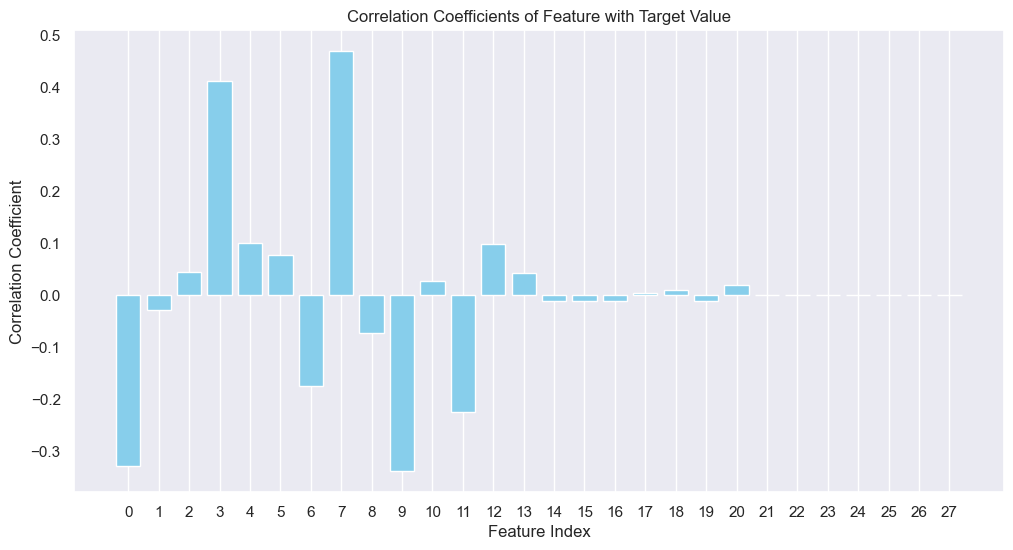

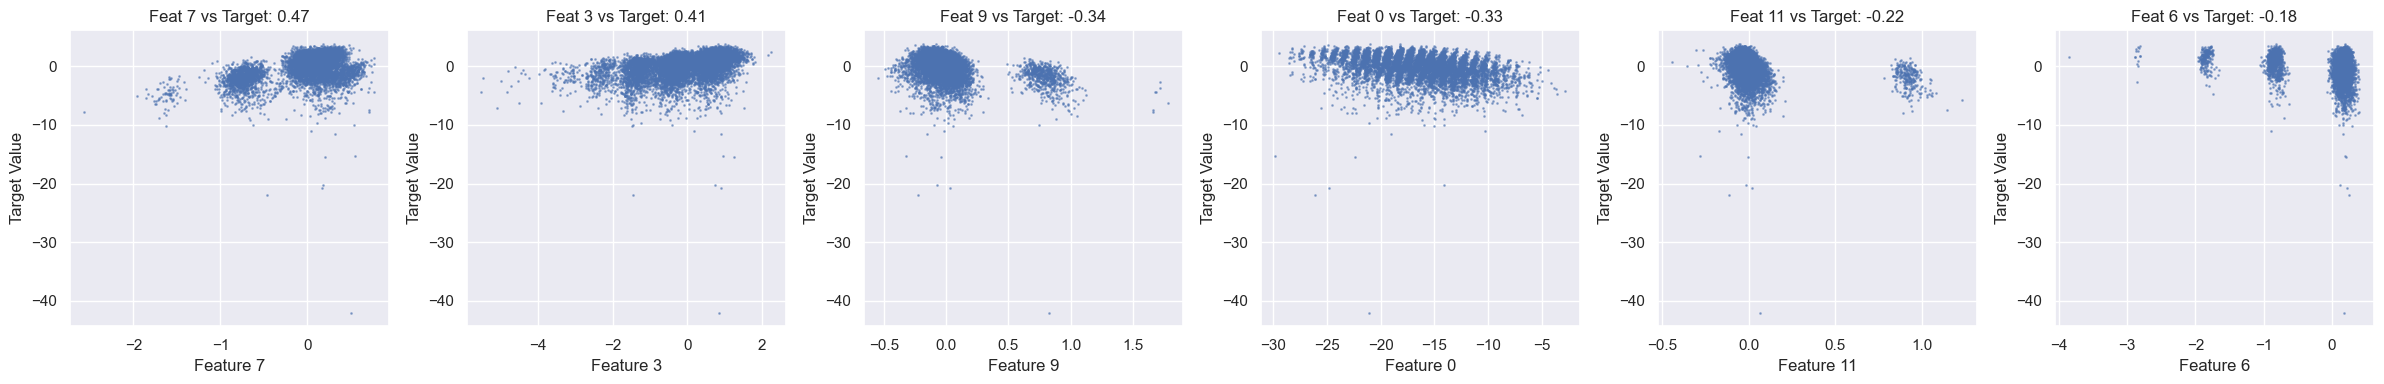

In [306]:
_, top_indices = featureTargetCorrelation(PrincipalComponents_bon, trainDataset_bon.y, top_n=6)

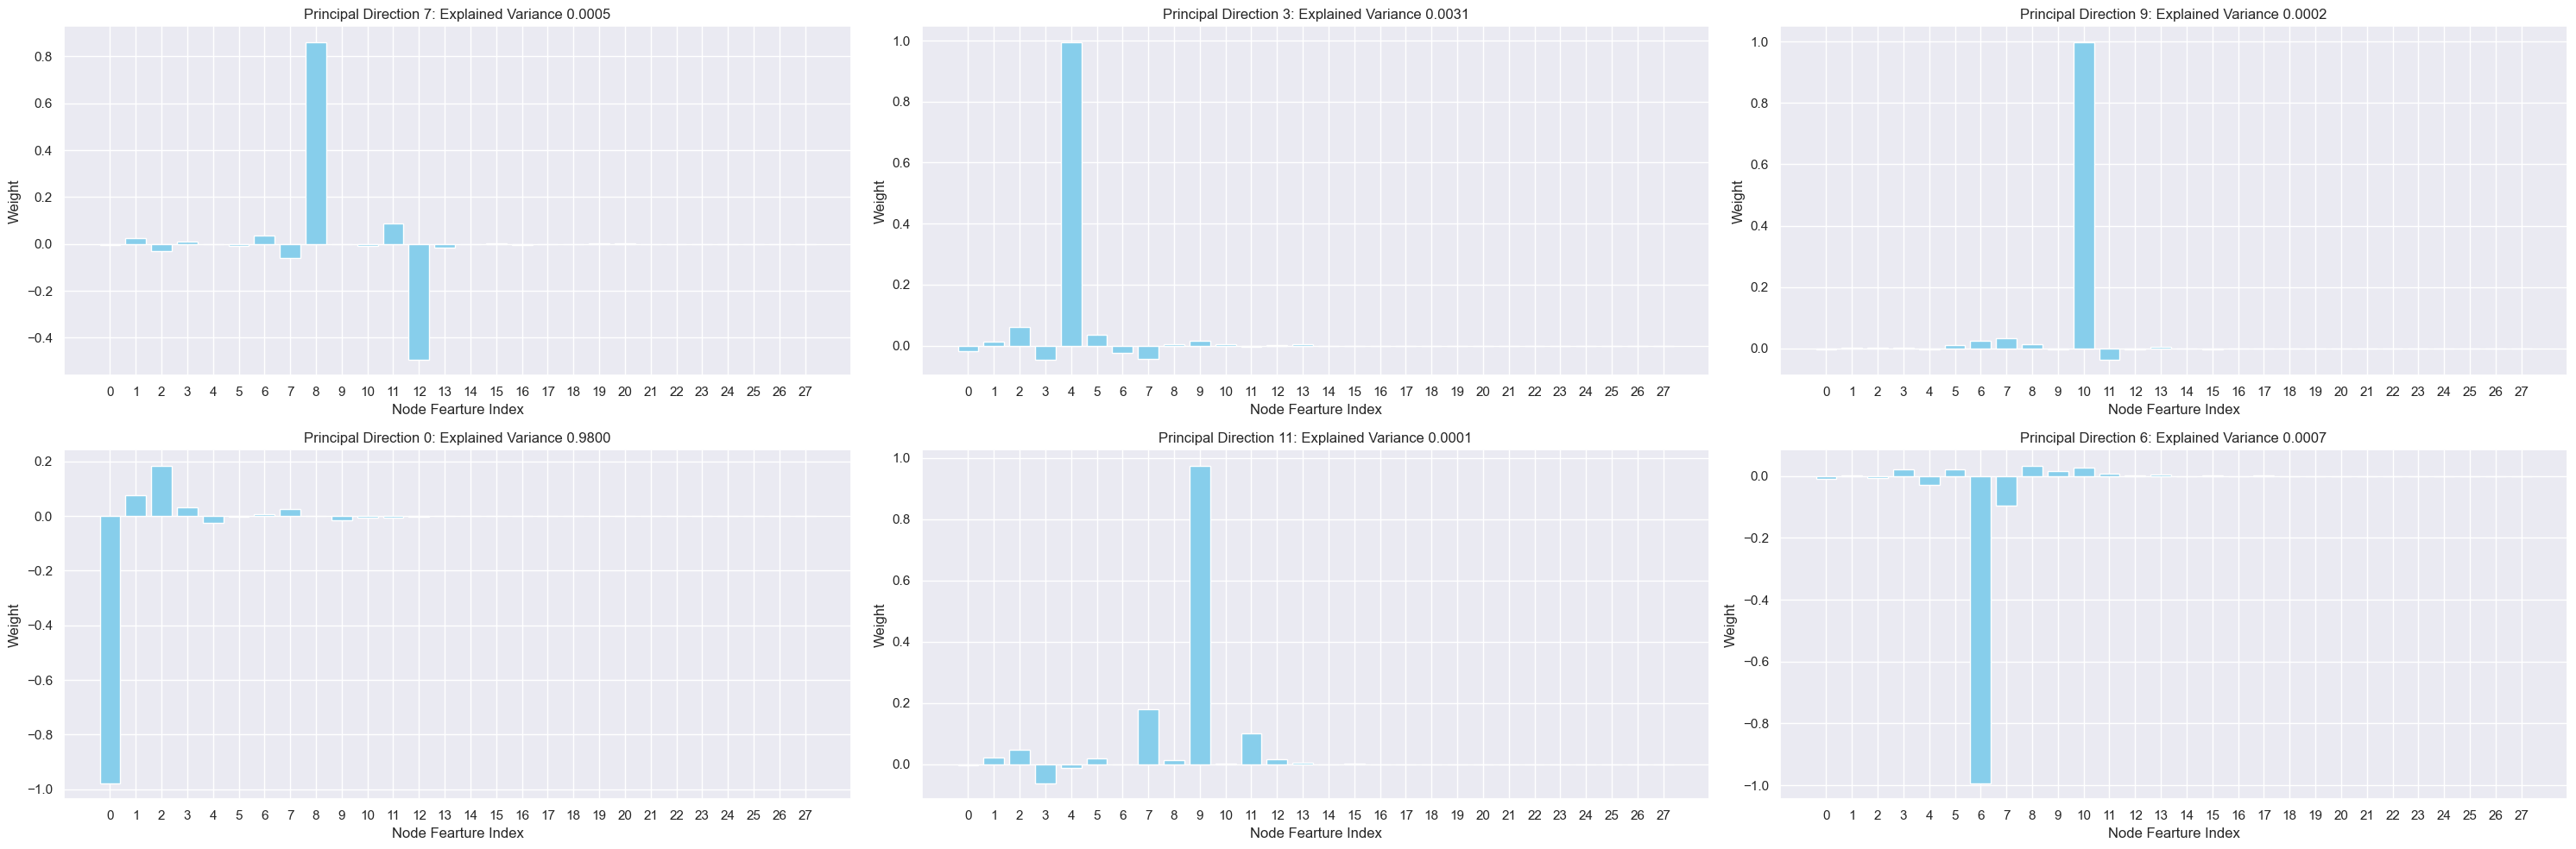

In [307]:
# Plot each Principal direction of the top 5 as a bar plot
Directions = V[:, top_indices.copy()]
fig, axes = plt.subplots(2, 3, figsize=(30, 10))
axes = axes.flatten()
for i, idx in enumerate(top_indices):
    axes[i].bar(range(Directions.shape[0]), Directions[:, i].numpy(), color='skyblue')
    axes[i].set_title(f'Principal Direction {idx}: Explained Variance {explained_variance[idx]:.4f}')
    axes[i].set_xlabel('Node Fearture Index')
    axes[i].set_ylabel('Weight')
    axes[i].set_xticks(range(0, Directions.shape[0]))
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [308]:
top5_principal_components = PrincipalComponents_bon[:, top_indices.copy()]
top5_principal_components_val = PrincipalComponents_bon_val[:, top_indices.copy()]

Selected Features: [0 3 4 5 6 7 9]
LASSO Mean Squared Error: 2.099360466003418
LASSO R^2 Score: 0.4669990539550781
LASSO Mean Absolute Error: 0.9315131902694702


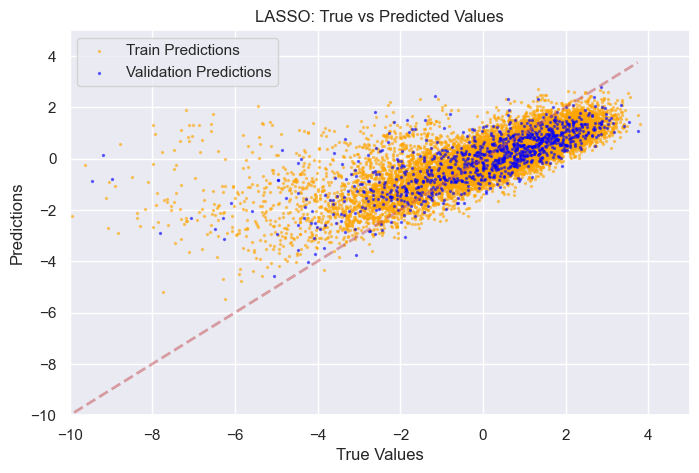

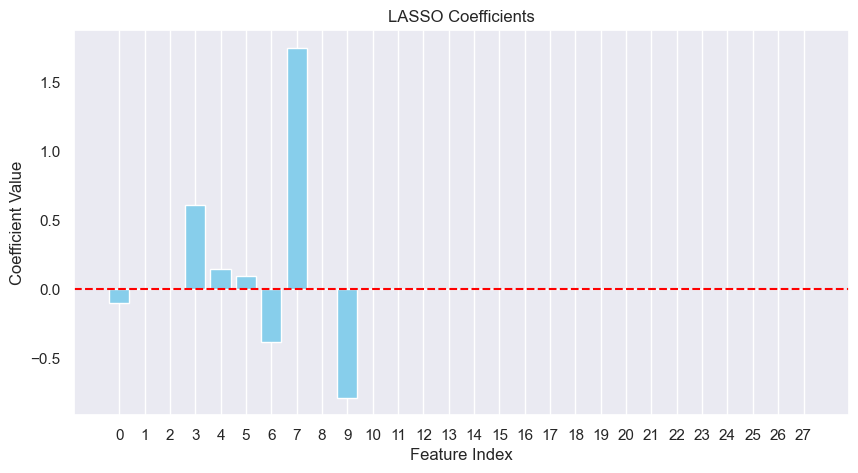

(array([0, 3, 4, 5, 6, 7, 9]),
 array([-0.09793907, -0.        ,  0.        ,  0.6119653 ,  0.15030916,
         0.09396825, -0.38213882,  1.7471126 , -0.        , -0.78412384,
         0.        , -0.        ,  0.        ,  0.        , -0.        ,
        -0.        , -0.        ,  0.        ,  0.        , -0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ], dtype=float32))

In [309]:
LASSOfeatureSelection(
    PrincipalComponents_bon,
    trainDataset_bon.y,
    PrincipalComponents_bon_val,
    valDataset_bon.y,
    alpha=0.1
)

Evaluating BON PCA...
LASSO Regression (alpha=0.1):
Train MSE: 2.1609, R2: 0.4656, MAE: 0.9578
Validation MSE: 2.1692, R2: 0.4493, MAE: 0.9523


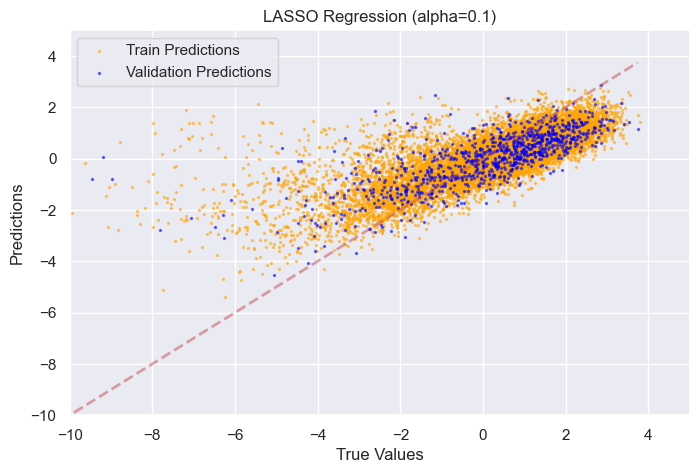

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   15.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Mean Squared Error: 1.664738408998092
R^2 Score: 0.5773440473134466
Mean Absolute Error: 0.7642312697632795


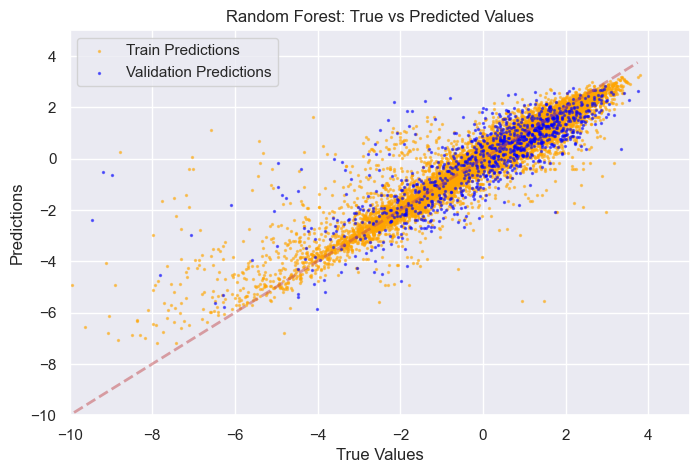

Mean Squared Error: 1.6482963562011719
R^2 Score: 0.5815184712409973
Mean Absolute Error: 0.7120629549026489


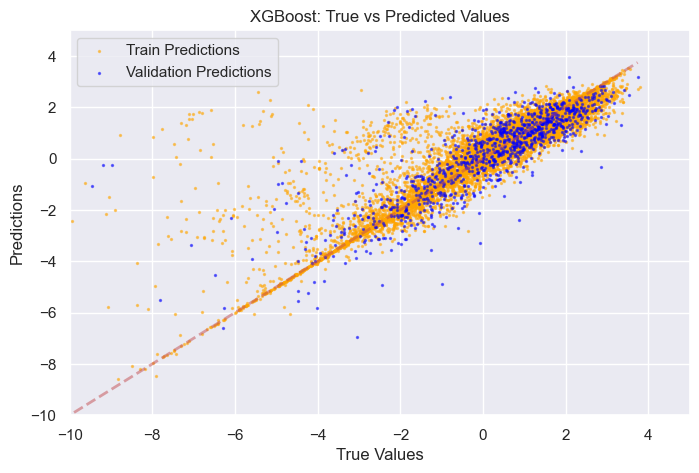

Mean Squared Error: 1.7431978476292957
R^2 Score: 0.5574241916756582
Mean Absolute Error: 0.7420173829060551


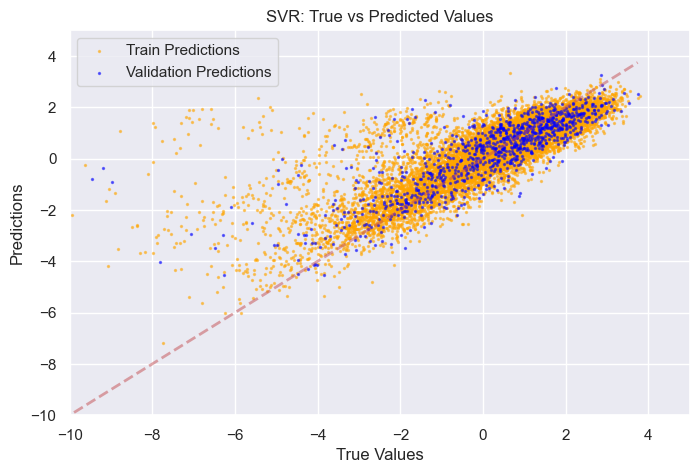

BON PCA - RF MAE: 0.7642312697632795, XGB MAE: 0.7120629549026489, SVR MAE: 0.7420173829060551


{'#Feats': 6,
 'LASSO': 0.952313451648016,
 'RF': 0.7642312697632795,
 'XGB': 0.7120629549026489,
 'SVR': 0.7420173829060551}

In [310]:
completeEvaluations(
    'BON PCA',
    EVALUATIONS,
    top5_principal_components,
    trainDataset_bon.y.numpy(),
    top5_principal_components_val,
    valDataset_bon.y.numpy()
)

Evaluating BON PCA top 5...
LASSO Regression (alpha=0.1):
Train MSE: 2.1609, R2: 0.4656, MAE: 0.9578
Validation MSE: 2.1692, R2: 0.4493, MAE: 0.9523


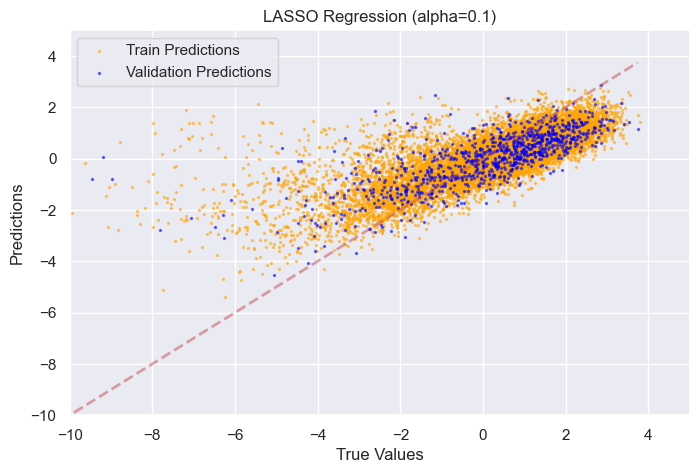

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   15.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Mean Squared Error: 1.664738408998092
R^2 Score: 0.5773440473134466
Mean Absolute Error: 0.7642312697632795


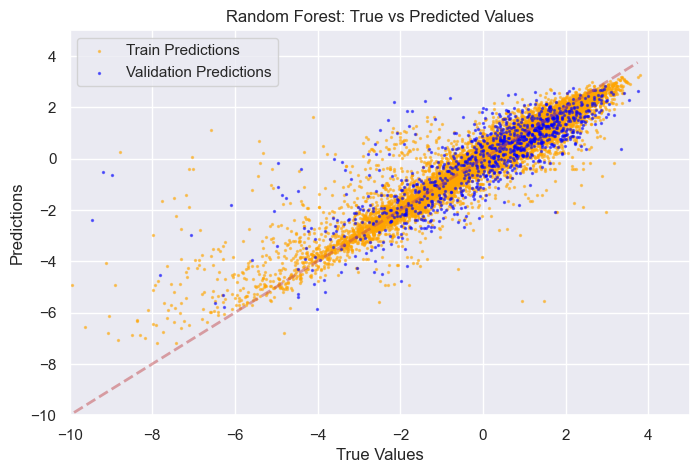

Mean Squared Error: 1.6482963562011719
R^2 Score: 0.5815184712409973
Mean Absolute Error: 0.7120629549026489


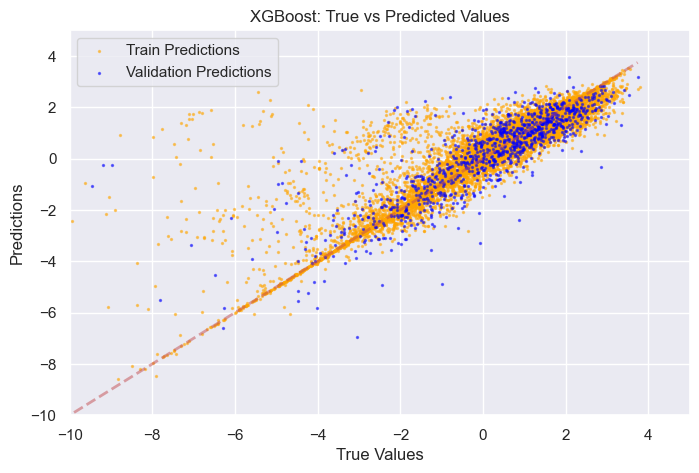

Mean Squared Error: 1.7431978476292957
R^2 Score: 0.5574241916756582
Mean Absolute Error: 0.7420173829060551


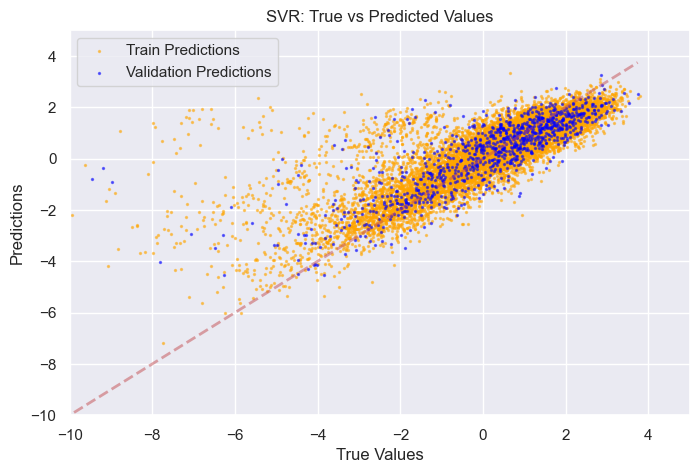

BON PCA top 5 - RF MAE: 0.7642312697632795, XGB MAE: 0.7120629549026489, SVR MAE: 0.7420173829060551


{'#Feats': 6,
 'LASSO': 0.952313451648016,
 'RF': 0.7642312697632795,
 'XGB': 0.7120629549026489,
 'SVR': 0.7420173829060551}

In [311]:
completeEvaluations(
    'BON PCA top 5',
    EVALUATIONS,
    top5_principal_components,
    trainDataset_bon.y.numpy(),
    top5_principal_components_val,
    valDataset_bon.y.numpy()
)

# Bag of Edges

In [312]:
from ACAgraphML.Transforms import OneHotEdgeFeats
oneHotEdgeTransform = OneHotEdgeFeats(
    nClasses=NUM_EDGE_FEATS,
)
trainDataset_edge = ZINC_Dataset.SMALL_TRAIN.load(transform=oneHotEdgeTransform)
valDataset_edge = ZINC_Dataset.SMALL_VAL.load(transform=oneHotEdgeTransform)

boe_train = [g.edge_attr.sum(dim=0) for g in trainDataset_edge]
boe_val = [g.edge_attr.sum(dim=0) for g in valDataset_edge]

boe_train = torch.stack(boe_train)
boe_val = torch.stack(boe_val)

c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning:

invalid value encountered in divide

c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning:

invalid value encountered in divide



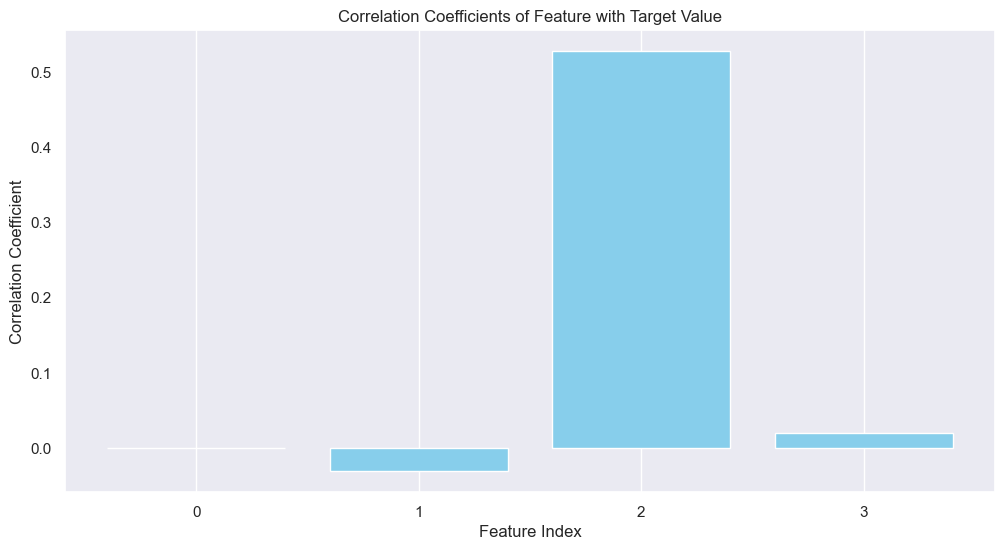

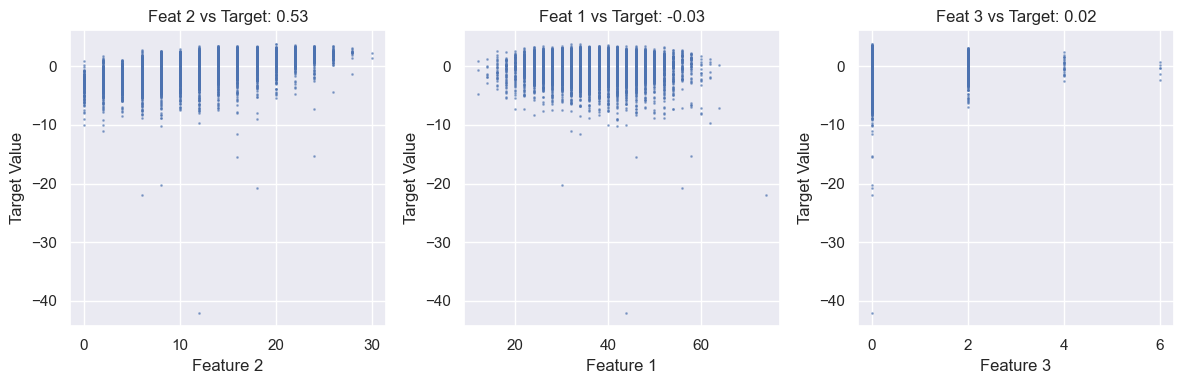

In [313]:
_, top_indices = featureTargetCorrelation(boe_train, trainDataset_edge.y, top_n=3)

In [314]:
topBoe_train = boe_train[:, top_indices.copy()]
topBoe_val = boe_val[:, top_indices.copy()]

Evaluating BOE...
LASSO Regression (alpha=0.1):
Train MSE: 2.7363, R2: 0.3233, MAE: 1.1799
Validation MSE: 2.7917, R2: 0.2912, MAE: 1.1932


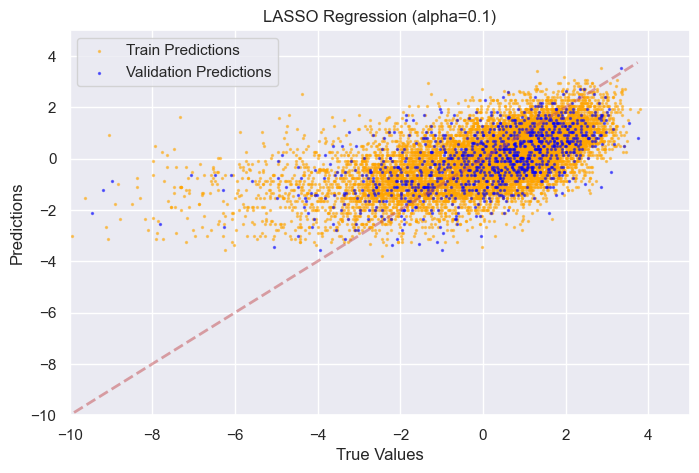

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Mean Squared Error: 3.004272203781308
R^2 Score: 0.23725341858176852
Mean Absolute Error: 1.1863908307263922


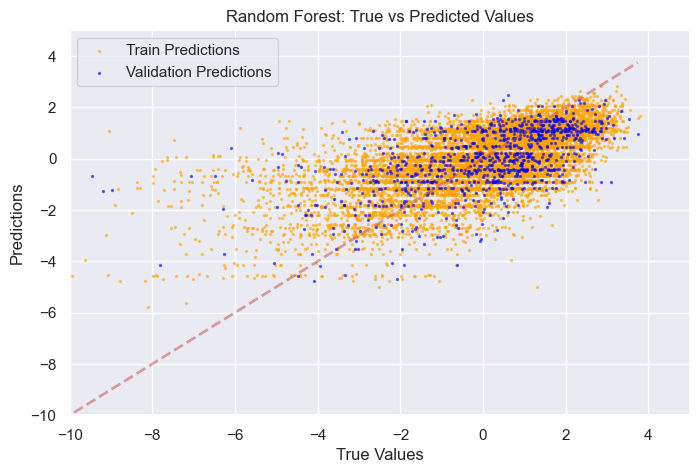

Mean Squared Error: 3.2283873558044434
R^2 Score: 0.18035340309143066
Mean Absolute Error: 1.1648105382919312


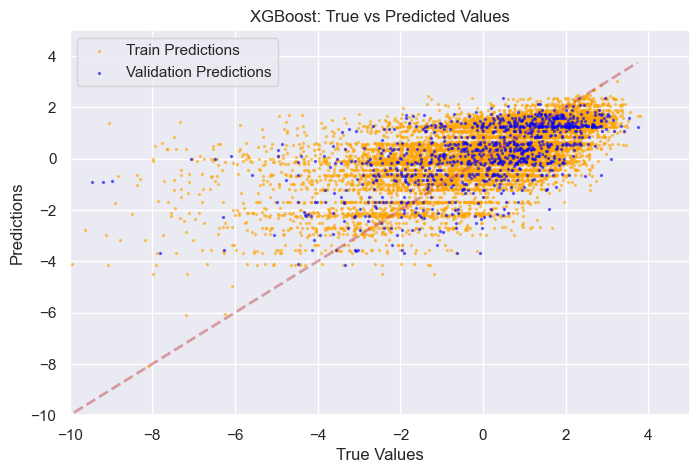

Mean Squared Error: 2.7499457302865227
R^2 Score: 0.3018236822143855
Mean Absolute Error: 1.1387689974960136


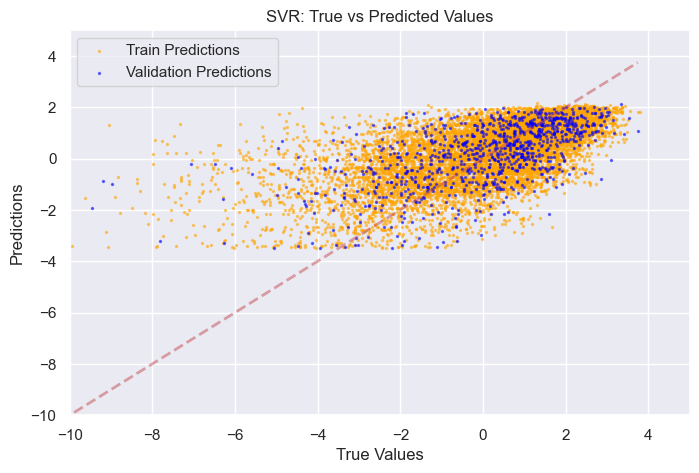

BOE - RF MAE: 1.1863908307263922, XGB MAE: 1.1648105382919312, SVR MAE: 1.1387689974960136


{'#Feats': 3,
 'LASSO': 1.1932461204176266,
 'RF': 1.1863908307263922,
 'XGB': 1.1648105382919312,
 'SVR': 1.1387689974960136}

In [315]:
completeEvaluations(
    'BOE',
    EVALUATIONS,
    topBoe_train,
    trainDataset_edge.y.numpy(),
    topBoe_val,
    valDataset_edge.y.numpy()
)

# BON + BOE

In [316]:
bon_boe = torch.cat((top5_principal_components, topBoe_train), dim=1)
bon_boe_val = torch.cat((top5_principal_components_val, topBoe_val), dim=1)

bon_boe.shape, bon_boe_val.shape

(torch.Size([10000, 9]), torch.Size([1000, 9]))

Evaluating BON + BOE...
LASSO Regression (alpha=0.1):
Train MSE: 2.0438, R2: 0.4945, MAE: 0.9536
Validation MSE: 2.1321, R2: 0.4587, MAE: 0.9786


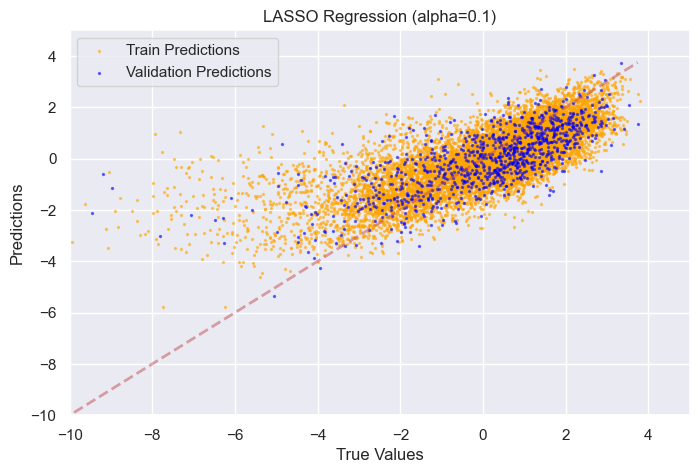

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   19.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Mean Squared Error: 1.5851938881046044
R^2 Score: 0.5975393915654401
Mean Absolute Error: 0.7160249481957678


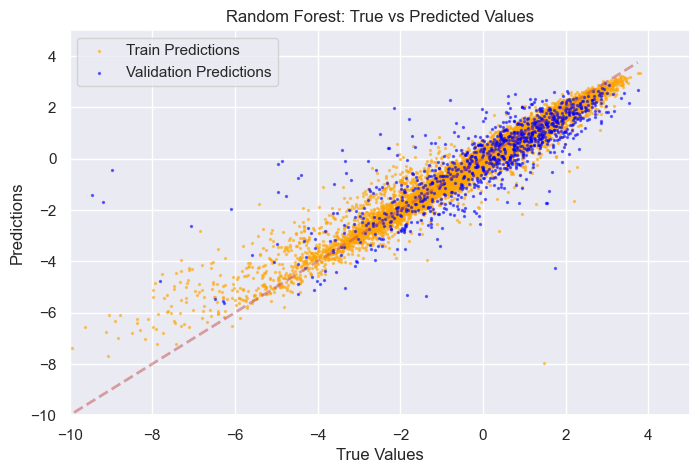

Mean Squared Error: 1.5484435558319092
R^2 Score: 0.6068698167800903
Mean Absolute Error: 0.6668535470962524


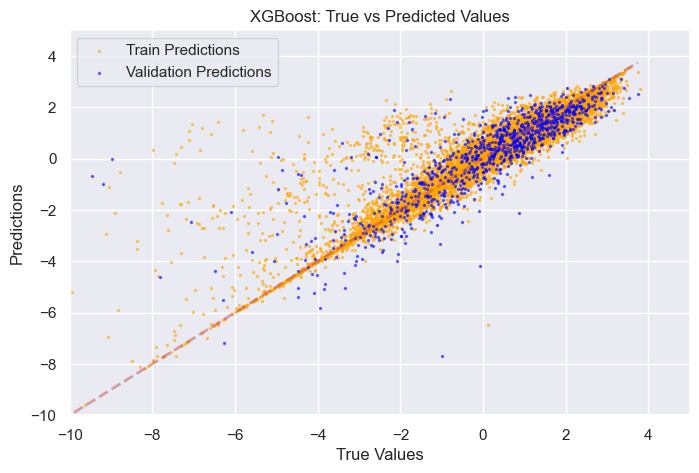

Mean Squared Error: 1.9553744900954122
R^2 Score: 0.5035552351629514
Mean Absolute Error: 0.8696432678696425


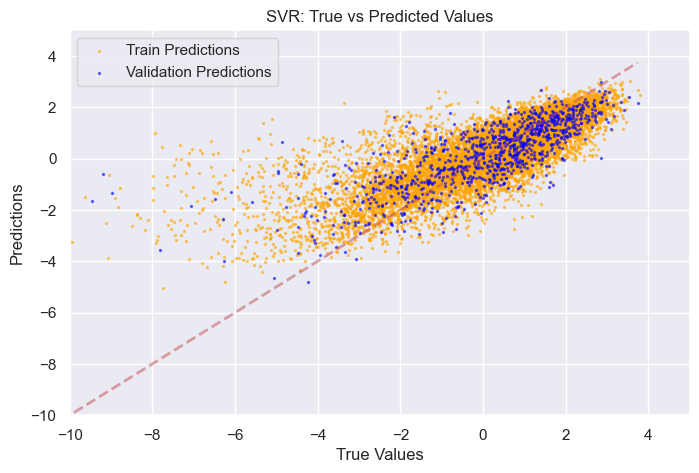

BON + BOE - RF MAE: 0.7160249481957678, XGB MAE: 0.6668535470962524, SVR MAE: 0.8696432678696425


{'#Feats': 9,
 'LASSO': 0.9785968611086792,
 'RF': 0.7160249481957678,
 'XGB': 0.6668535470962524,
 'SVR': 0.8696432678696425}

In [317]:
completeEvaluations(
    'BON + BOE',
    EVALUATIONS,
    bon_boe,
    trainDataset_bon.y.numpy(),
    bon_boe_val,
    valDataset_bon.y.numpy()
)

# Bag of degrees

In [318]:
from torch_geometric.transforms import OneHotDegree
degreeTransform = OneHotDegree(max_degree=4)
trainDataset_bod = ZINC_Dataset.SMALL_TRAIN.load(transform=degreeTransform)
valDataset_bod = ZINC_Dataset.SMALL_VAL.load(transform=degreeTransform)

bod_train = [g.x[:, -4:].sum(dim=0) for g in trainDataset_bod]
bod_val = [g.x[:, -4:].sum(dim=0) for g in valDataset_bod]

bod_train = torch.stack(bod_train)
bod_val = torch.stack(bod_val)
bod_train.shape, bod_val.shape

(torch.Size([10000, 4]), torch.Size([1000, 4]))

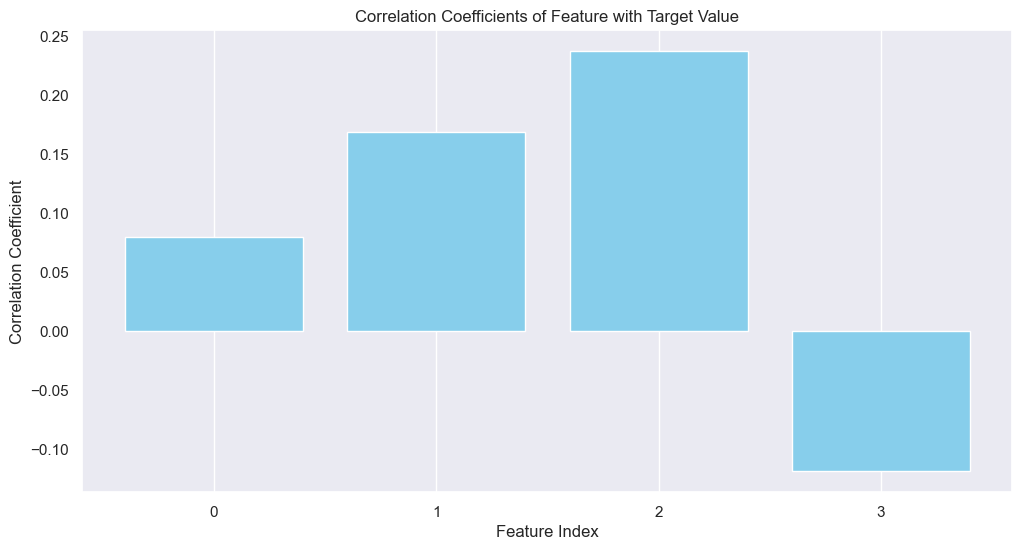

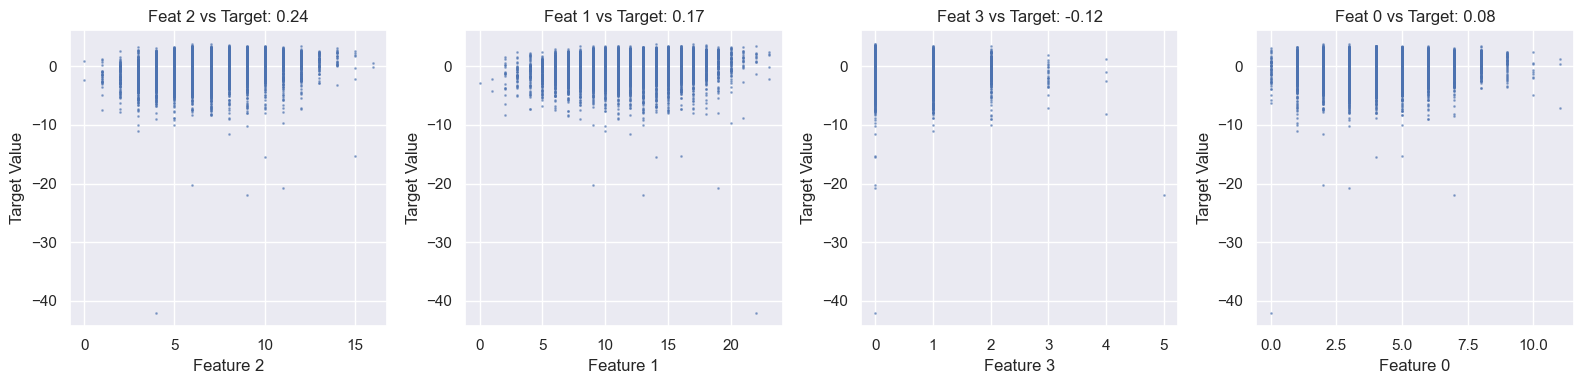

In [319]:
_, top_indices_bod = featureTargetCorrelation(bod_train, trainDataset_bon.y, top_n=4)

Evaluating BOD...
LASSO Regression (alpha=0.1):
Train MSE: 3.7462, R2: 0.0735, MAE: 1.4273
Validation MSE: 3.6860, R2: 0.0642, MAE: 1.4223


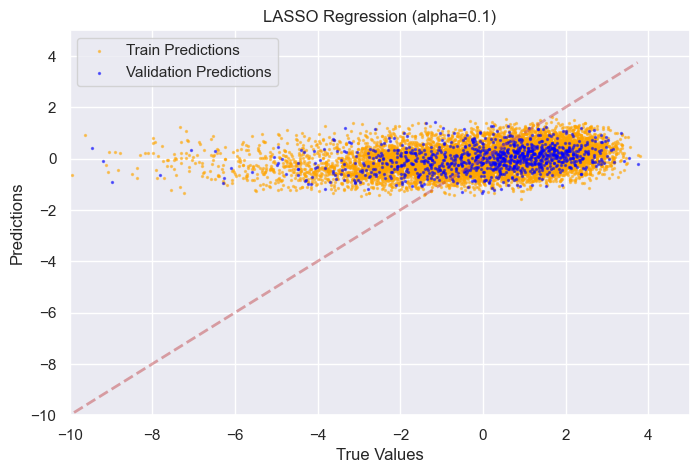

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Mean Squared Error: 3.6639643938926607
R^2 Score: 0.06976594452318674
Mean Absolute Error: 1.4113200226401872


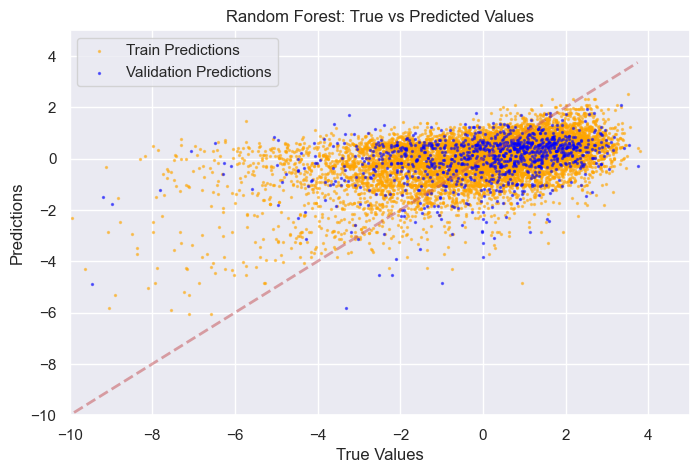

Mean Squared Error: 3.663774013519287
R^2 Score: 0.06981432437896729
Mean Absolute Error: 1.3512166738510132


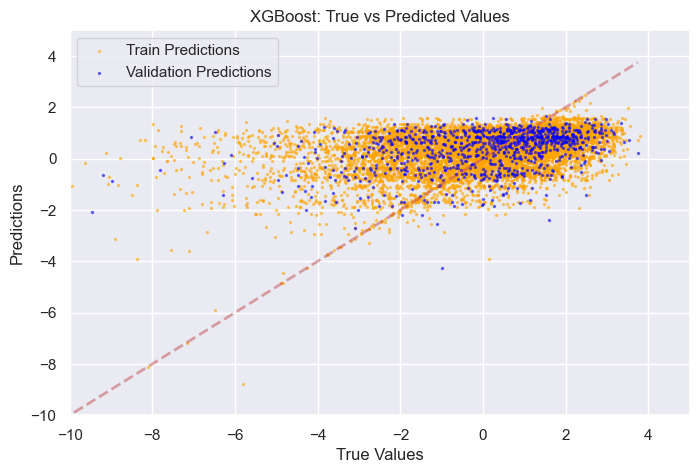

Mean Squared Error: 3.654167571776694
R^2 Score: 0.07225323331423261
Mean Absolute Error: 1.3474285291082393


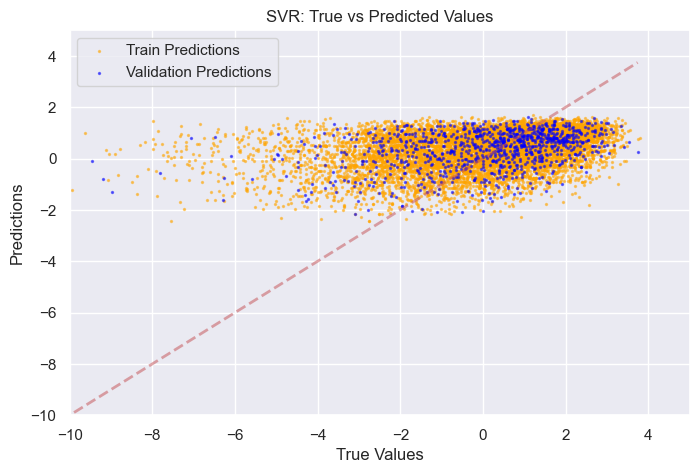

BOD - RF MAE: 1.4113200226401872, XGB MAE: 1.3512166738510132, SVR MAE: 1.3474285291082393


{'#Feats': 4,
 'LASSO': 1.4222521733217945,
 'RF': 1.4113200226401872,
 'XGB': 1.3512166738510132,
 'SVR': 1.3474285291082393}

In [320]:
completeEvaluations(
    'BOD',
    EVALUATIONS,
    bod_train[:, top_indices_bod.copy()],
    trainDataset_bon.y.numpy(),
    bod_val[:, top_indices_bod.copy()],
    valDataset_bon.y.numpy()
)

# BON + BOD

In [321]:
bon_bod = torch.cat((top5_principal_components, bod_train), dim=1)
bon_bod_val = torch.cat((top5_principal_components_val, bod_val), dim=1)

bon_bod.shape, bon_bod_val.shape

(torch.Size([10000, 10]), torch.Size([1000, 10]))

Evaluating BON + BOD...
LASSO Regression (alpha=0.1):
Train MSE: 2.1339, R2: 0.4722, MAE: 0.9522
Validation MSE: 2.1548, R2: 0.4529, MAE: 0.9492


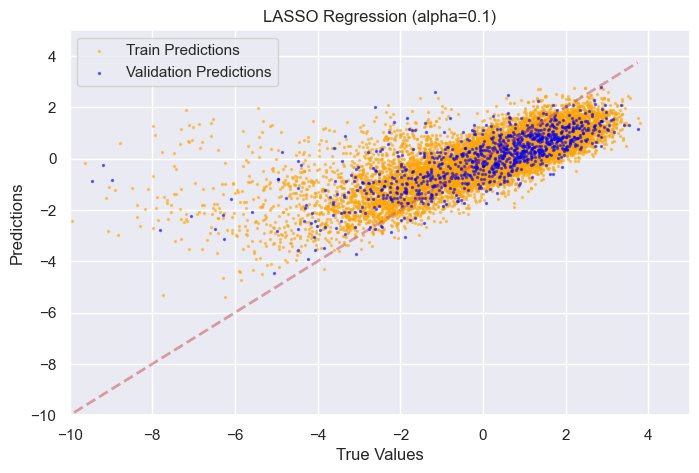

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   21.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Mean Squared Error: 1.6191902775422258
R^2 Score: 0.5889081397795761
Mean Absolute Error: 0.7237505395639278


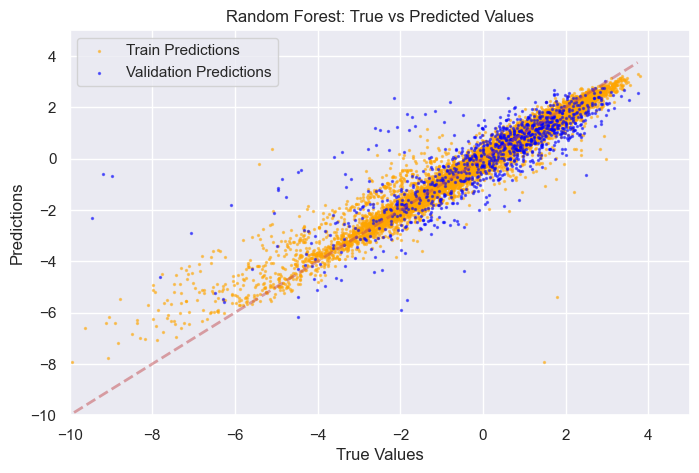

Mean Squared Error: 1.5266445875167847
R^2 Score: 0.6124043464660645
Mean Absolute Error: 0.6581193804740906


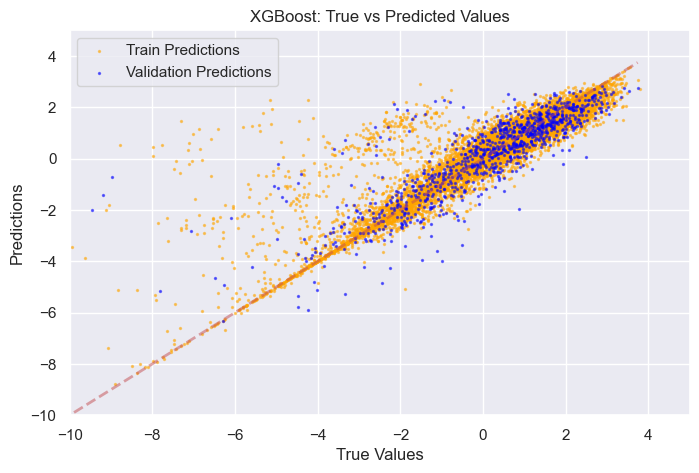

Mean Squared Error: 1.7625597489805087
R^2 Score: 0.5525084506696312
Mean Absolute Error: 0.7573457183188418


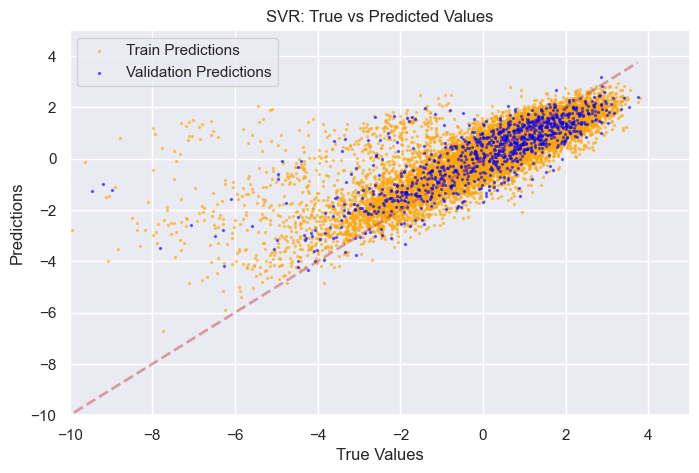

BON + BOD - RF MAE: 0.7237505395639278, XGB MAE: 0.6581193804740906, SVR MAE: 0.7573457183188418


{'#Feats': 10,
 'LASSO': 0.9492068122317768,
 'RF': 0.7237505395639278,
 'XGB': 0.6581193804740906,
 'SVR': 0.7573457183188418}

In [322]:
completeEvaluations(
    'BON + BOD',
    EVALUATIONS,
    bon_bod,
    trainDataset_bon.y.numpy(),
    bon_bod_val,
    valDataset_bon.y.numpy()
)

# BON + BOE + BOD

In [323]:
bon_boe_bod = torch.cat((bon_boe, bod_train), dim=1)
bon_boe_bod_val = torch.cat((bon_boe_val, bod_val), dim=1)

bon_boe_bod.shape, bon_boe_bod_val.shape

(torch.Size([10000, 13]), torch.Size([1000, 13]))

Evaluating BON + BOE + BOD...
LASSO Regression (alpha=0.1):
Train MSE: 2.0388, R2: 0.4958, MAE: 0.9545
Validation MSE: 2.1306, R2: 0.4591, MAE: 0.9796


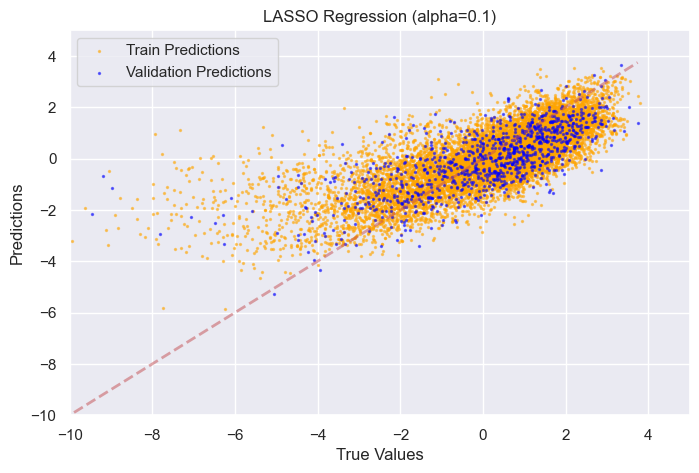

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   25.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Mean Squared Error: 1.527495324953324
R^2 Score: 0.6121883244221202
Mean Absolute Error: 0.6909653032596759


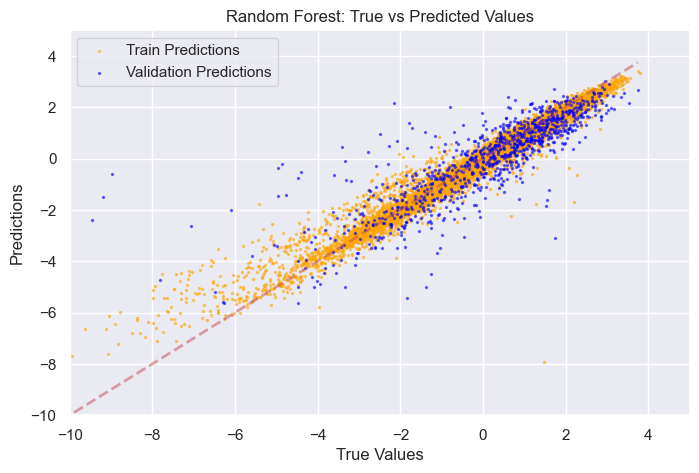

Mean Squared Error: 1.4560705423355103
R^2 Score: 0.6303221583366394
Mean Absolute Error: 0.6349133849143982


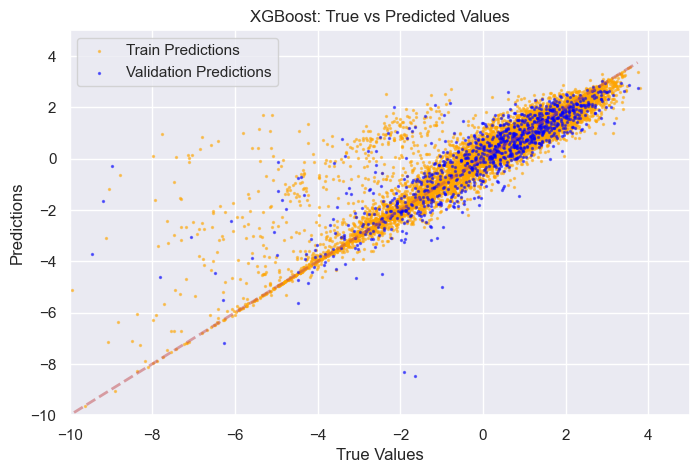

Mean Squared Error: 1.9518732809878303
R^2 Score: 0.5044441477169728
Mean Absolute Error: 0.8700840412110895


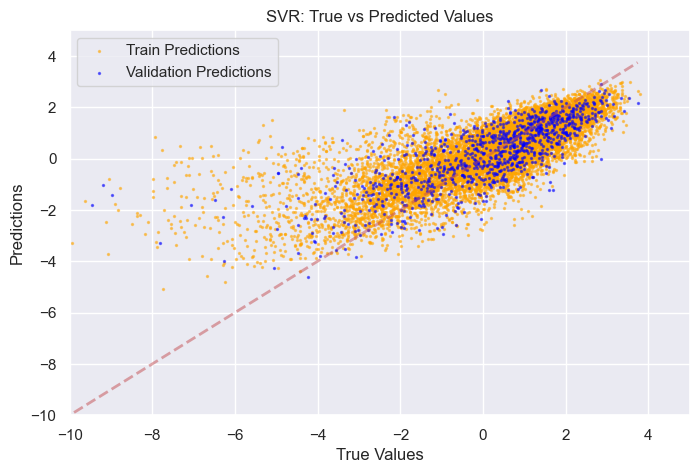

BON + BOE + BOD - RF MAE: 0.6909653032596759, XGB MAE: 0.6349133849143982, SVR MAE: 0.8700840412110895


{'#Feats': 13,
 'LASSO': 0.9796298098731027,
 'RF': 0.6909653032596759,
 'XGB': 0.6349133849143982,
 'SVR': 0.8700840412110895}

In [324]:
completeEvaluations(
    'BON + BOE + BOD',
    EVALUATIONS,
    bon_boe_bod,
    trainDataset_bon.y.numpy(),
    bon_boe_bod_val,
    valDataset_bon.y.numpy()
)

# Steady State Embeddings

In [325]:
from ACAgraphML.Transforms import SteadyStateTransform
steadyStateTransform = SteadyStateTransform(useEdgeWeights=False)

trainDataset_ss = ZINC_Dataset.SMALL_TRAIN.load(transform=steadyStateTransform)
valDataset_ss = ZINC_Dataset.SMALL_VAL.load(transform=steadyStateTransform)


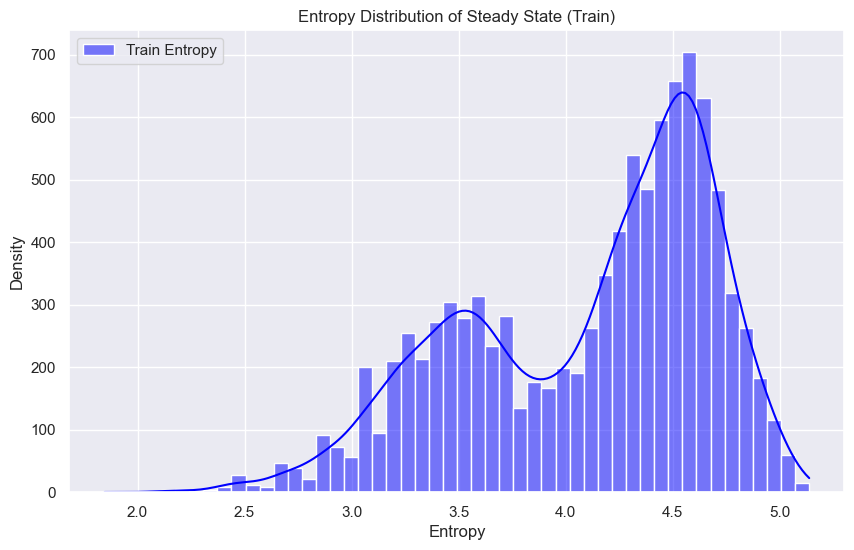

In [326]:
#Compute entropy of the steady state distribution
def computeEntropy(steady_state):
    entropy = -torch.sum(steady_state * torch.log2(steady_state + 1e-10), dim=0)
    return entropy

steady_state_train = torch.stack([computeEntropy(g.x[:, 1]) for g in trainDataset_ss])
steady_state_val = torch.stack([computeEntropy(g.x[:, 1]) for g in valDataset_ss])

# Plot the entropy distribution of training
plt.figure(figsize=(10, 6))
sns.histplot(steady_state_train.numpy(), bins=50, kde=True, color='blue', label='Train Entropy')
plt.title('Entropy Distribution of Steady State (Train)')
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()
plt.show()

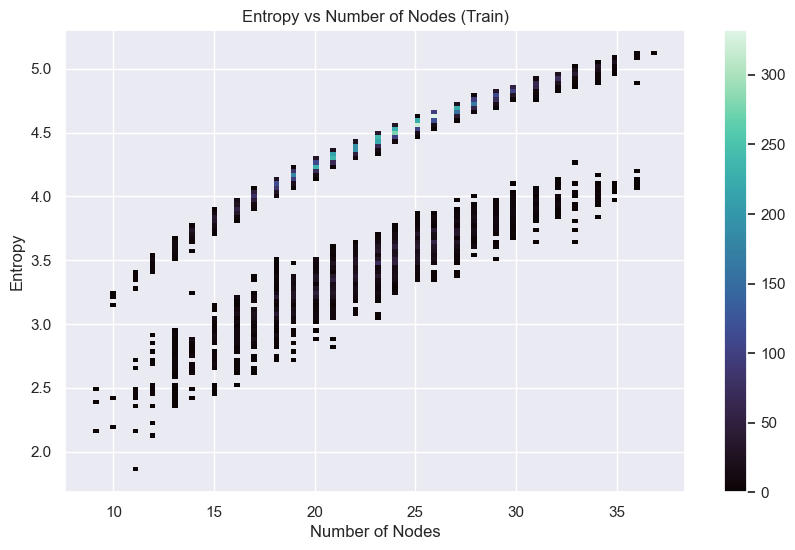

In [327]:
#Plot entropy vs number of nodes distribution using sns
plt.figure(figsize=(10, 6))
sns.histplot(
    x=[g.num_nodes for g in trainDataset_ss],
    y=steady_state_train.numpy(),
    bins=100,
    cmap="mako",
    cbar=True,
    kde=True
)
plt.title('Entropy vs Number of Nodes (Train)')
plt.xlabel('Number of Nodes')
plt.ylabel('Entropy')
plt.show()

In [328]:
bon_entropy_train = torch.cat((top5_principal_components, steady_state_train.unsqueeze(1)), dim=1)
bon_entropy_val = torch.cat((top5_principal_components_val, steady_state_val.unsqueeze(1)), dim=1)

Evaluating BON top 5 + Steady State Entropy...
LASSO Regression (alpha=0.1):
Train MSE: 2.1609, R2: 0.4656, MAE: 0.9578
Validation MSE: 2.1692, R2: 0.4493, MAE: 0.9523


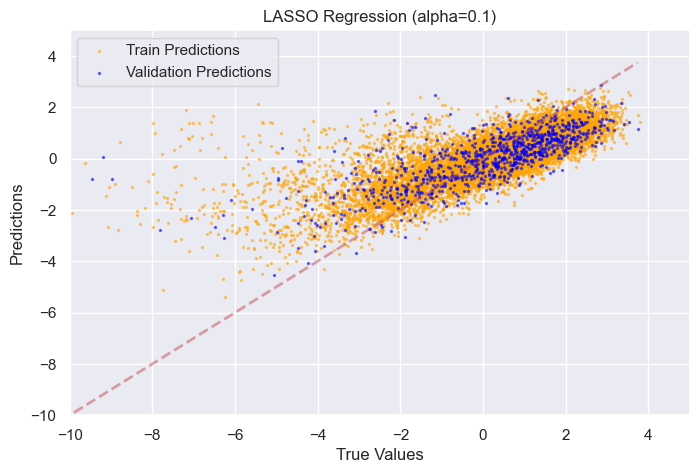

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   19.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Mean Squared Error: 1.7827287610081175
R^2 Score: 0.5473877945069575
Mean Absolute Error: 0.7789729263193488


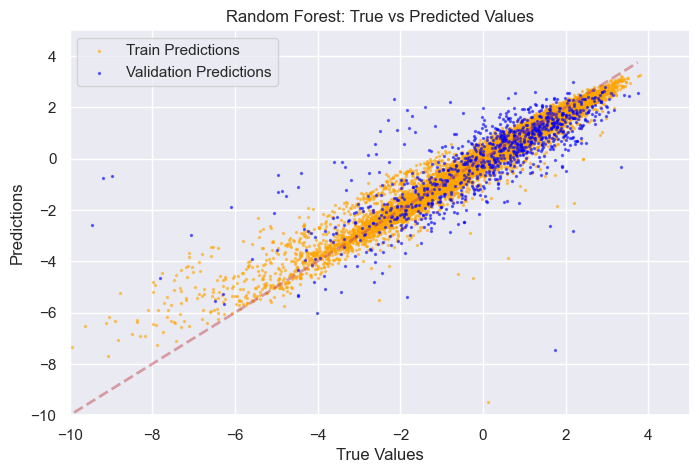

Mean Squared Error: 1.6062523126602173
R^2 Score: 0.5921928882598877
Mean Absolute Error: 0.7023910880088806


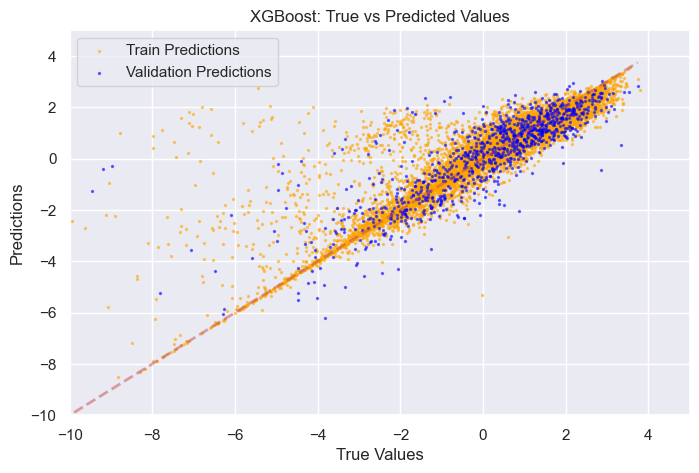

Mean Squared Error: 1.753401421513275
R^2 Score: 0.554833633773329
Mean Absolute Error: 0.7468431212123323


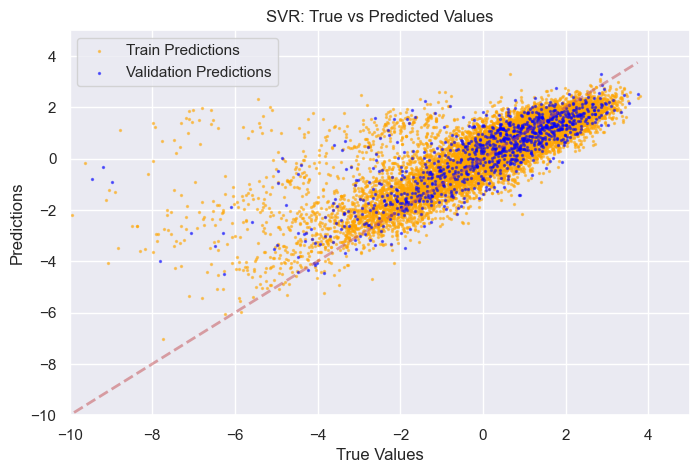

BON top 5 + Steady State Entropy - RF MAE: 0.7789729263193488, XGB MAE: 0.7023910880088806, SVR MAE: 0.7468431212123323


{'#Feats': 7,
 'LASSO': 0.952313451648016,
 'RF': 0.7789729263193488,
 'XGB': 0.7023910880088806,
 'SVR': 0.7468431212123323}

In [329]:
completeEvaluations(
    'BON top 5 + Steady State Entropy',
    EVALUATIONS,
    bon_entropy_train,
    trainDataset_bon.y.numpy(),
    bon_entropy_val,
    valDataset_bon.y.numpy()
)

Evaluating BON + BOE + BOD + SSE...
LASSO Regression (alpha=0.1):
Train MSE: 2.0388, R2: 0.4958, MAE: 0.9545
Validation MSE: 2.1306, R2: 0.4591, MAE: 0.9796


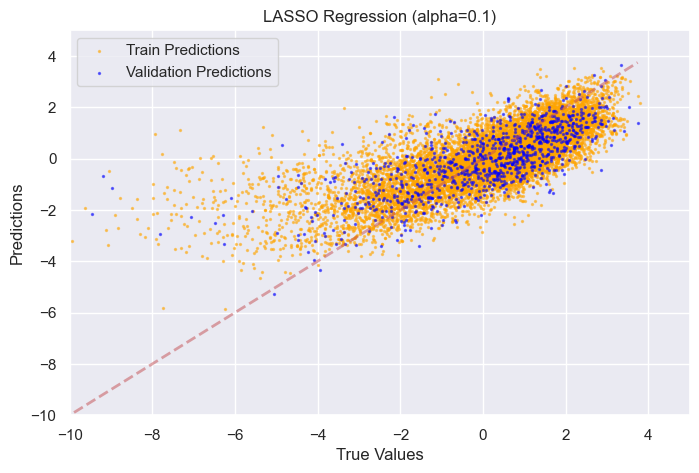

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   27.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Mean Squared Error: 1.5057774140554983
R^2 Score: 0.6177022263488541
Mean Absolute Error: 0.6858139141332529


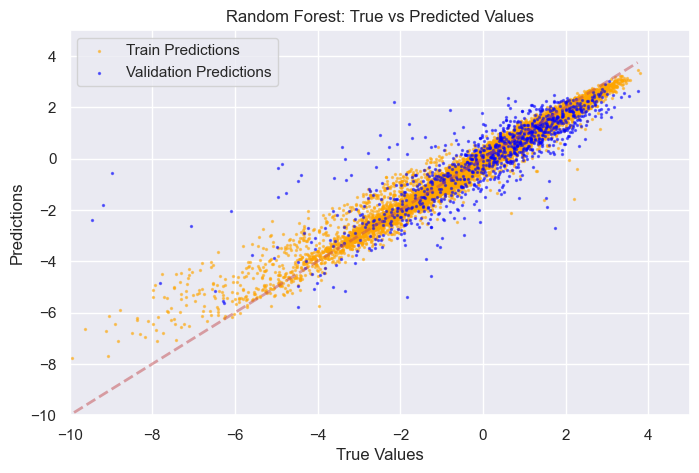

Mean Squared Error: 1.4088441133499146
R^2 Score: 0.6423123478889465
Mean Absolute Error: 0.6261171102523804


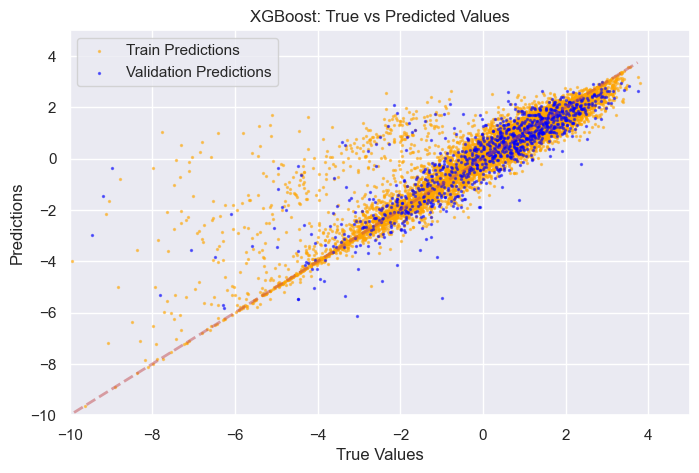

Mean Squared Error: 1.9521084225891436
R^2 Score: 0.5043844482488868
Mean Absolute Error: 0.8701050184585922


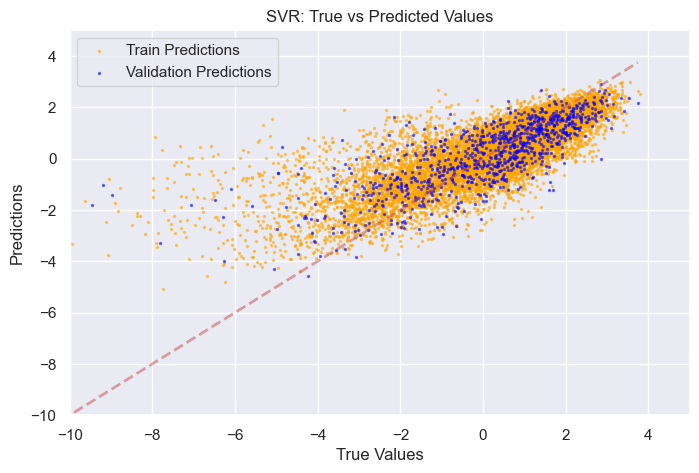

BON + BOE + BOD + SSE - RF MAE: 0.6858139141332529, XGB MAE: 0.6261171102523804, SVR MAE: 0.8701050184585922


{'#Feats': 14,
 'LASSO': 0.9796298098731027,
 'RF': 0.6858139141332529,
 'XGB': 0.6261171102523804,
 'SVR': 0.8701050184585922}

In [330]:
bon_boe_bod_ss = torch.cat((bon_boe_bod, steady_state_train.unsqueeze(1)), dim=1)
bon_boe_bod_ss_val = torch.cat((bon_boe_bod_val, steady_state_val.unsqueeze(1)), dim=1)
completeEvaluations(
    'BON + BOE + BOD + SSE',
    EVALUATIONS,
    bon_boe_bod_ss,
    trainDataset_bon.y.numpy(),
    bon_boe_bod_ss_val,
    valDataset_bon.y.numpy()
)

In [331]:
trainDataset_ss[0].x[:, -1]

tensor([0.0202, 0.0221, 0.0605, 0.0222, 0.0403, 0.0337, 0.0400, 0.0227, 0.0595,
        0.0114, 0.0348, 0.0384, 0.0377, 0.0368, 0.0262, 0.0534, 0.0562, 0.0172,
        0.0172, 0.0494, 0.0302, 0.0473, 0.0154, 0.0315, 0.0302, 0.0262, 0.0368,
        0.0599, 0.0224])

In [332]:
trainDataset_bon[0].x

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [333]:
(trainDataset_bon[0].x * trainDataset_ss[0].x[:, [-1]]).sum(dim=0)

tensor([0.7375, 0.0679, 0.1384, 0.0000, 0.0000, 0.0562, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])

In [334]:
#ss weighted BON
ssWbon_train = [(trainDataset_bon[i].x * g.x[:, [-1]]).sum(dim=0) for i, g in enumerate(trainDataset_ss)]
ssWbon_val = [(valDataset_bon[i].x * g.x[:, [-1]]).sum(dim=0) for i, g in enumerate(valDataset_ss)]
ssWbon_train = torch.stack(ssWbon_train, dim=0)
ssWbon_val = torch.stack(ssWbon_val, dim=0)

ssWbon_train.shape, ssWbon_val.shape

(torch.Size([10000, 28]), torch.Size([1000, 28]))

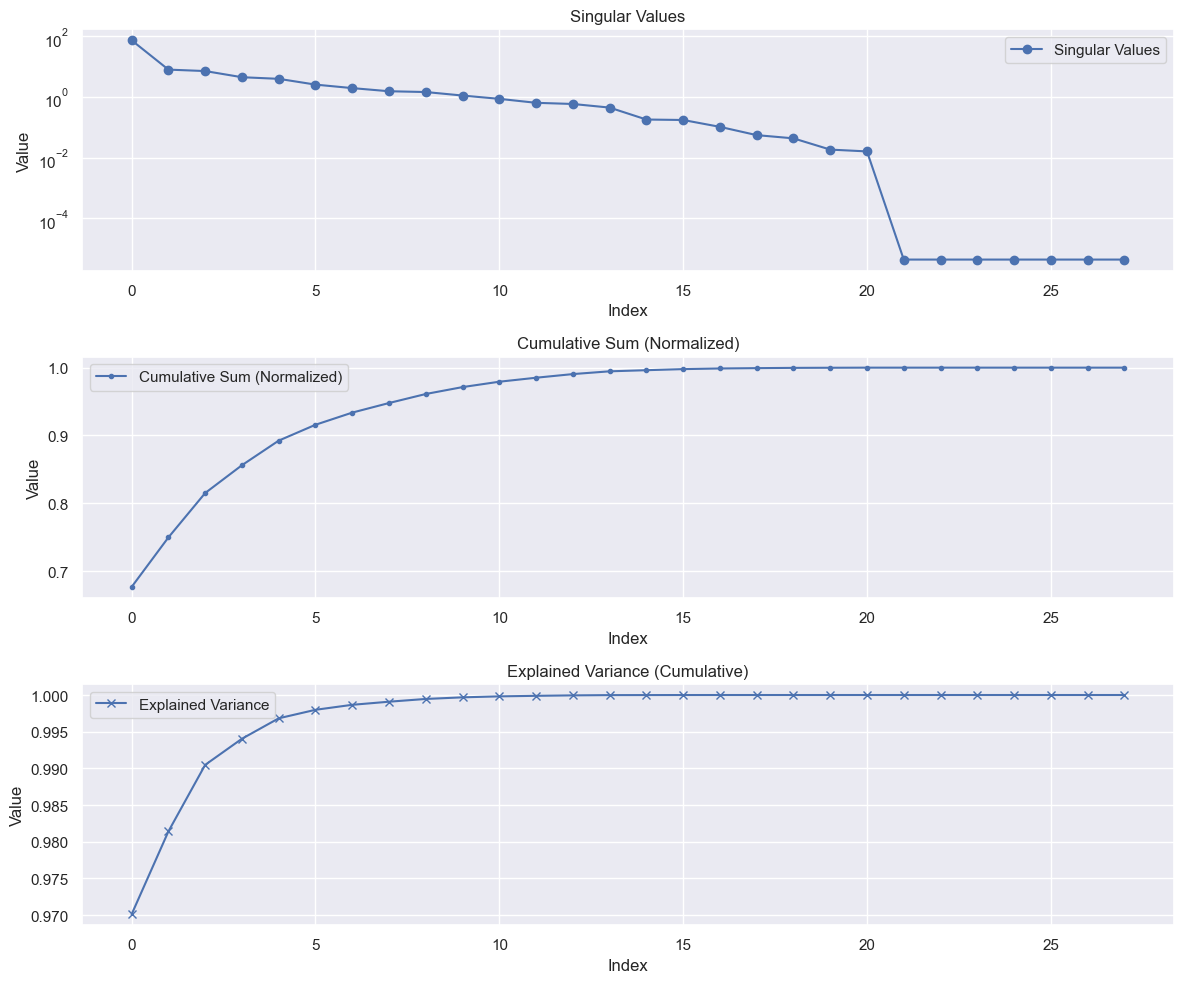

In [335]:
#PCA on ssWbonTrain
_, S, V = torch.linalg.svd(ssWbon_train.float(), full_matrices=False)
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
axes[0].semilogy(S, marker='o', label='Singular Values')
axes[0].set_title('Singular Values')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Value')
axes[0].legend()
cumsum_norm = torch.cumsum(S, dim=0) / torch.sum(S)
axes[1].plot(cumsum_norm.numpy(), marker='.', label='Cumulative Sum (Normalized)')
axes[1].set_title('Cumulative Sum (Normalized)')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Value')
axes[1].legend()
explained_variance = S**2 / torch.sum(S**2)
explained_variance_cumsum = torch.cumsum(explained_variance, dim=0)
axes[2].plot(explained_variance_cumsum.numpy(), marker='x', label='Explained Variance')
axes[2].set_title('Explained Variance (Cumulative)')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Value')
axes[2].legend()
plt.tight_layout()
plt.show()

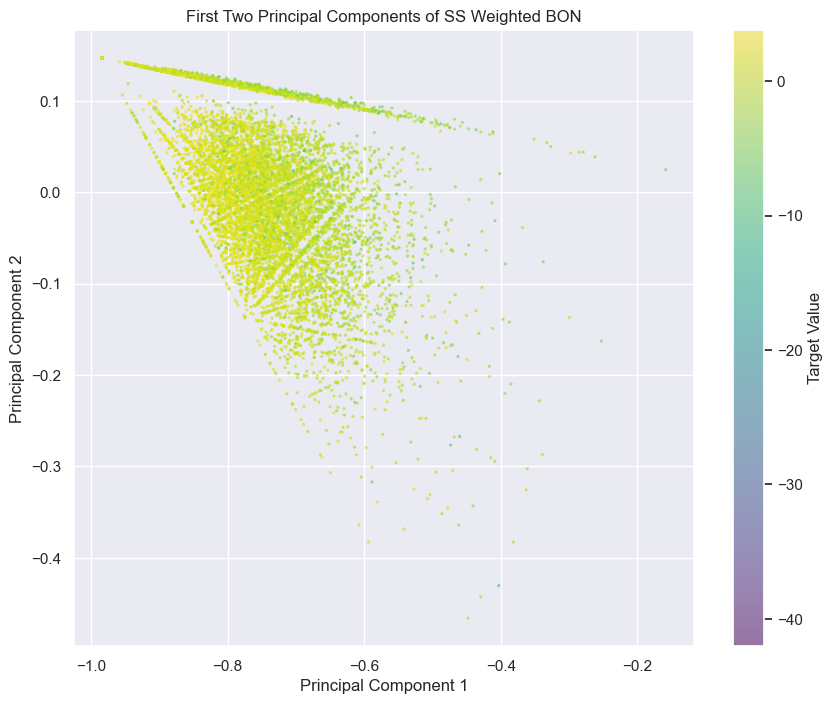

In [336]:
ss_weighted_Phi = ssWbon_train.float() @ V.T
plt.figure(figsize=(10, 8))
plt.scatter(ss_weighted_Phi[:, 0], ss_weighted_Phi[:, 1], alpha=0.5, s=2, c=trainDataset_bon.y, cmap='viridis')
plt.title('First Two Principal Components of SS Weighted BON')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Target Value')
plt.show()

In [337]:
ss_weighted_PrincipalComponents = ss_weighted_Phi
ss_weighted_PrincipalComponents_val = ssWbon_val.float() @ V.T

Evaluating SSW BON...
LASSO Regression (alpha=0.1):
Train MSE: 4.0434, R2: 0.0000, MAE: 1.5109
Validation MSE: 3.9390, R2: -0.0001, MAE: 1.4785


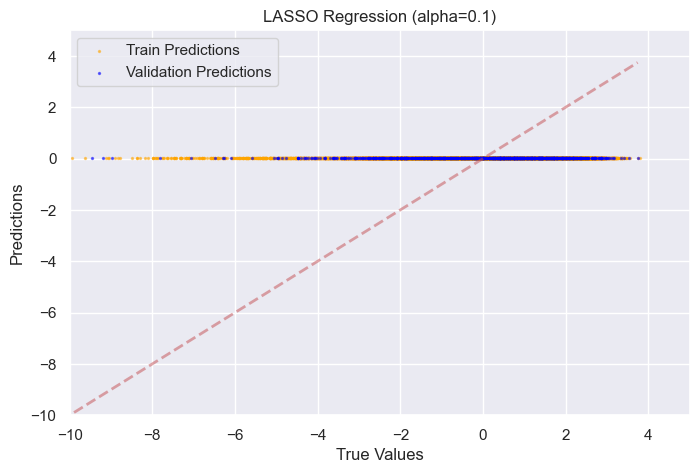

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Mean Squared Error: 2.062416738204468
R^2 Score: 0.47637856698030767
Mean Absolute Error: 0.9337126195141909


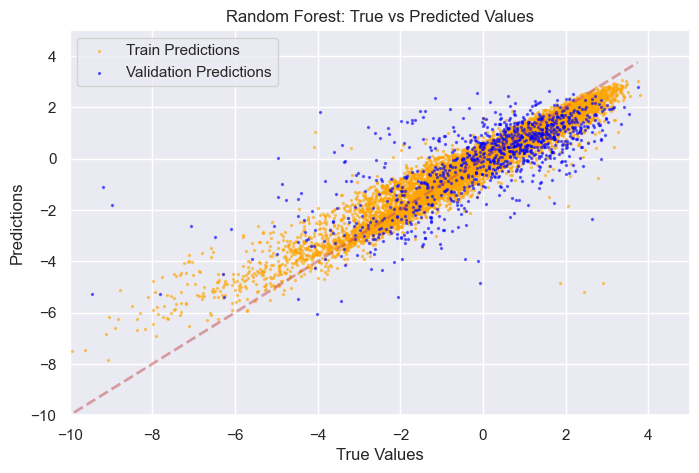

Mean Squared Error: 1.9962888956069946
R^2 Score: 0.49316757917404175
Mean Absolute Error: 0.8917080163955688


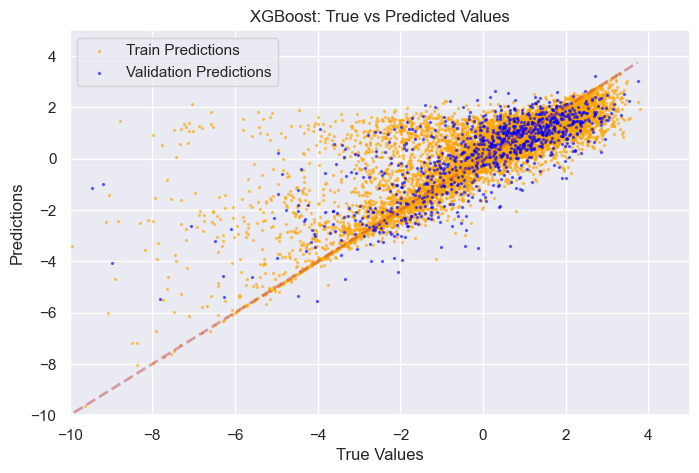

Mean Squared Error: 2.2241609278846606
R^2 Score: 0.43531377012616446
Mean Absolute Error: 0.9317500898893825


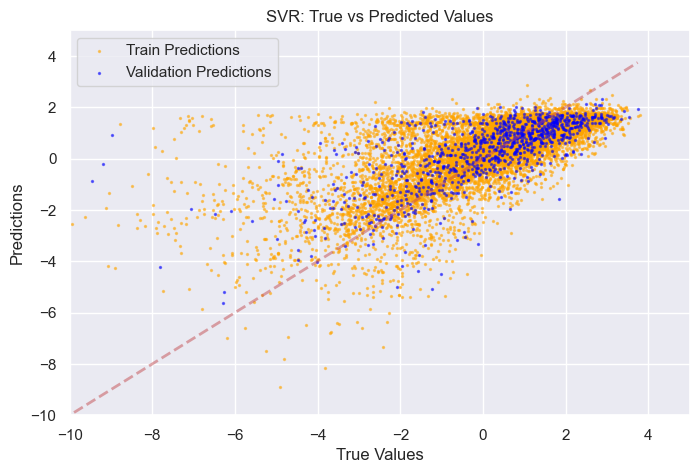

SSW BON - RF MAE: 0.9337126195141909, XGB MAE: 0.8917080163955688, SVR MAE: 0.9317500898893825


{'#Feats': 28,
 'LASSO': 1.4785104238663516,
 'RF': 0.9337126195141909,
 'XGB': 0.8917080163955688,
 'SVR': 0.9317500898893825}

In [338]:
completeEvaluations(
    'SSW BON',
    EVALUATIONS,
    ss_weighted_PrincipalComponents,
    trainDataset_bon.y.numpy(),
    ss_weighted_PrincipalComponents_val,
    valDataset_bon.y.numpy()
)

# Master Node Embeddings

In [371]:
from ACAgraphML.Transforms import AddMasterNode
masterNodeTransform = AddMasterNode(node_feature_init='mean', edge_feature_init='zero')
trainDataset_masterNode = ZINC_Dataset.SMALL_TRAIN.load(transform=masterNodeTransform)
valDataset_masterNode = ZINC_Dataset.SMALL_VAL.load(transform=masterNodeTransform)

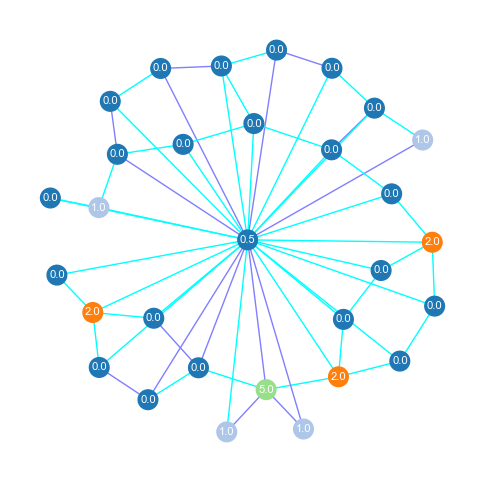

In [372]:
from ACAgraphML.Plotting import plotGraph
plotGraph(trainDataset_masterNode[0])

## RandomWalksEmbeddings

In [367]:
randomWalkTransform = T.AddRandomWalkPE(walk_length=10, attr_name='random_walk_pe')
transform = T.Compose([
    masterNodeTransform,
    randomWalkTransform
])
trainDataset_rw = ZINC_Dataset.SMALL_TRAIN.load(transform=transform)
valDataset_rw = ZINC_Dataset.SMALL_VAL.load(transform=transform)

trainDataset_rw[0].x.shape, trainDataset_rw[0].edge_attr.shape, trainDataset_rw[0].random_walk_pe.shape

(torch.Size([30, 1]), torch.Size([122, 1]), torch.Size([30, 10]))

In [349]:
random_walk_pe_master_train = torch.stack([g.random_walk_pe[-1] for g in trainDataset_rw])
random_walk_pe_master_val = torch.stack([g.random_walk_pe[-1] for g in valDataset_rw])

random_walk_pe_master_train.shape, random_walk_pe_master_val.shape

(torch.Size([10000, 10]), torch.Size([1000, 10]))

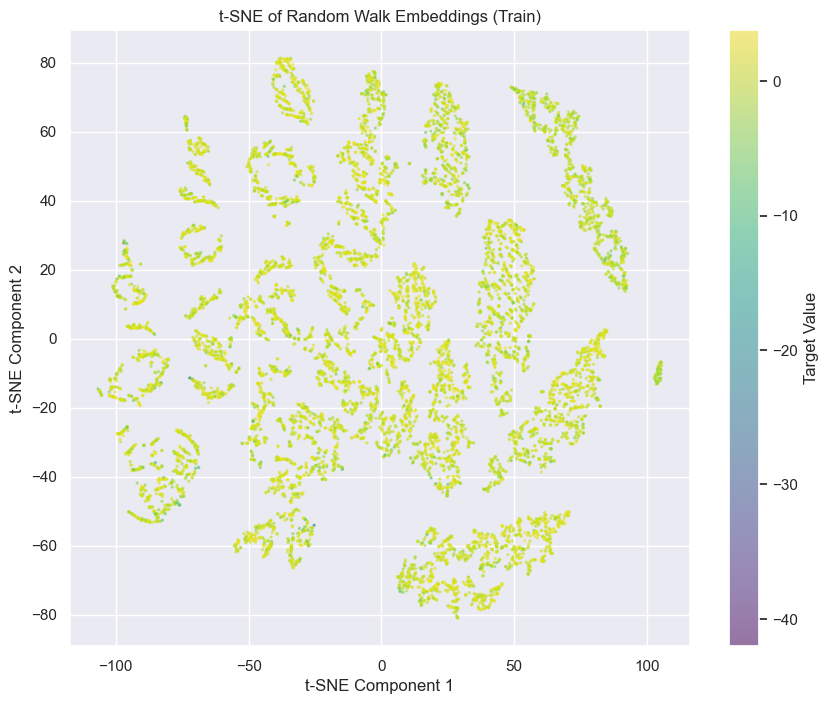

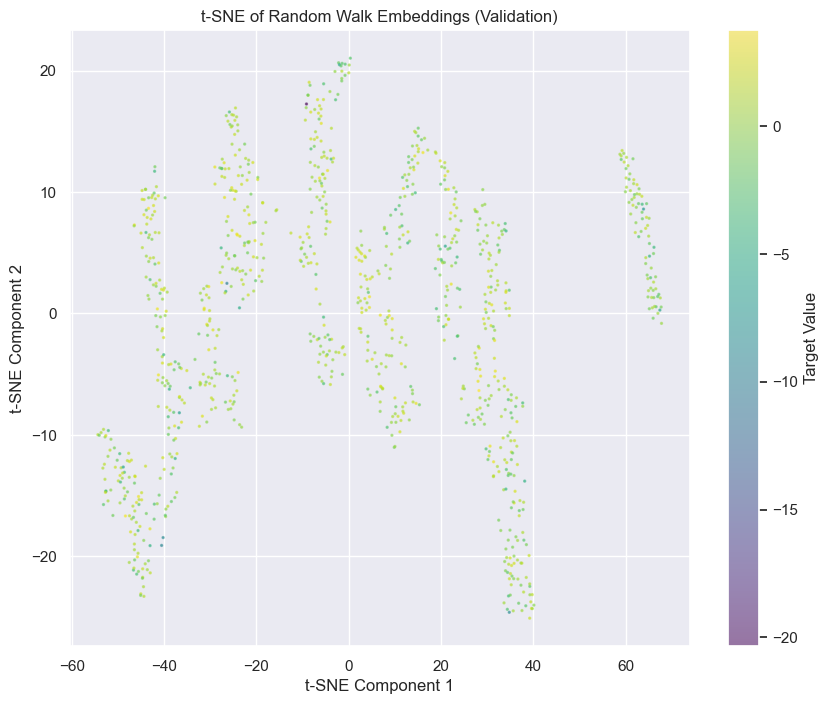

In [350]:
# Plot tsne of the random walk embeddings coloring the points by the target value
from sklearn.manifold import TSNE
def plot_tsne_embeddings(embeddings, labels, title='t-SNE of Embeddings'):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(embeddings.numpy())
    
    plt.figure(figsize=(5, 4))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels.numpy(), cmap='viridis', s=2, alpha=0.5)
    plt.colorbar(scatter, label='Target Value')
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

plot_tsne_embeddings(random_walk_pe_master_train, trainDataset_rw.y, title='t-SNE of Random Walk Embeddings (Train)')
plot_tsne_embeddings(random_walk_pe_master_val, valDataset_rw.y, title='t-SNE of Random Walk Embeddings (Validation)')

Evaluating RWPE MN...
LASSO Regression (alpha=0.1):
Train MSE: 4.0434, R2: 0.0000, MAE: 1.5109
Validation MSE: 3.9390, R2: -0.0001, MAE: 1.4785


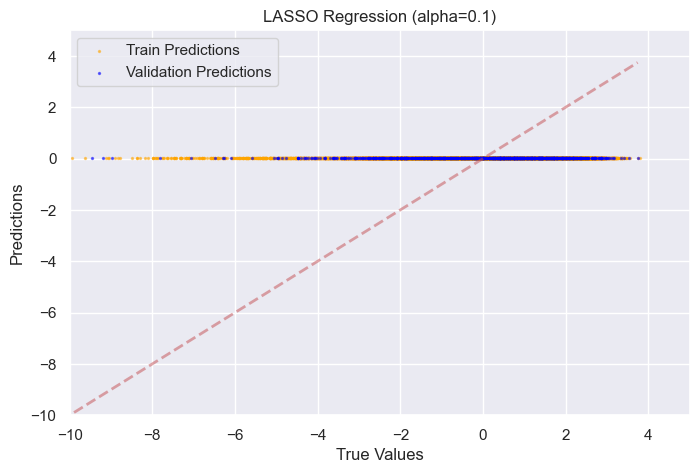

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   33.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Mean Squared Error: 3.661266925416174
R^2 Score: 0.07045079753228967
Mean Absolute Error: 1.4383961271951753


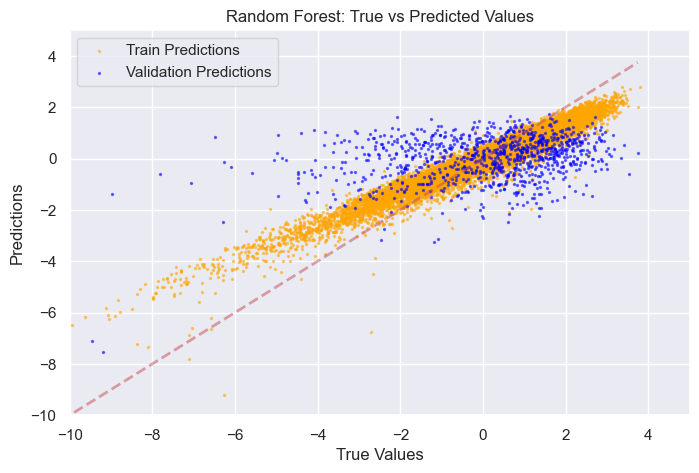

Mean Squared Error: 3.992507219314575
R^2 Score: -0.013646960258483887
Mean Absolute Error: 1.4418638944625854


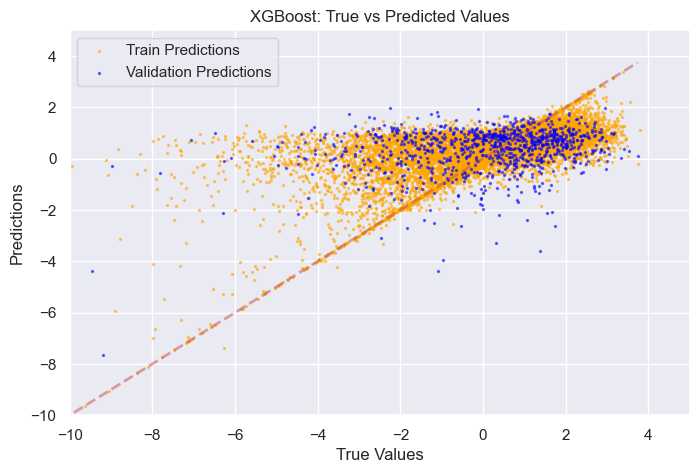

Mean Squared Error: 4.092132789023071
R^2 Score: -0.03894057655902361
Mean Absolute Error: 1.4317186714497188


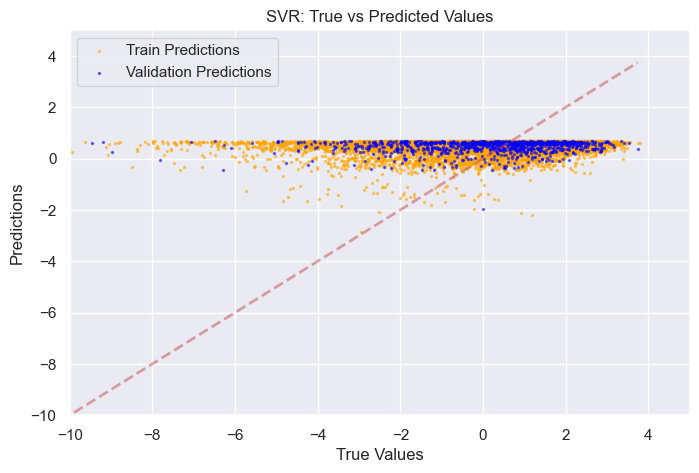

RWPE MN - RF MAE: 1.4383961271951753, XGB MAE: 1.4418638944625854, SVR MAE: 1.4317186714497188


{'#Feats': 10,
 'LASSO': 1.4785104238663516,
 'RF': 1.4383961271951753,
 'XGB': 1.4418638944625854,
 'SVR': 1.4317186714497188}

In [351]:
completeEvaluations(
    'RWPE MN',
    EVALUATIONS,
    random_walk_pe_master_train,
    trainDataset_rw.y.numpy(),
    random_walk_pe_master_val,
    valDataset_rw.y.numpy()
)

Evaluating RWPE BON...
LASSO Regression (alpha=0.1):
Train MSE: 2.1609, R2: 0.4656, MAE: 0.9578
Validation MSE: 2.1692, R2: 0.4493, MAE: 0.9523


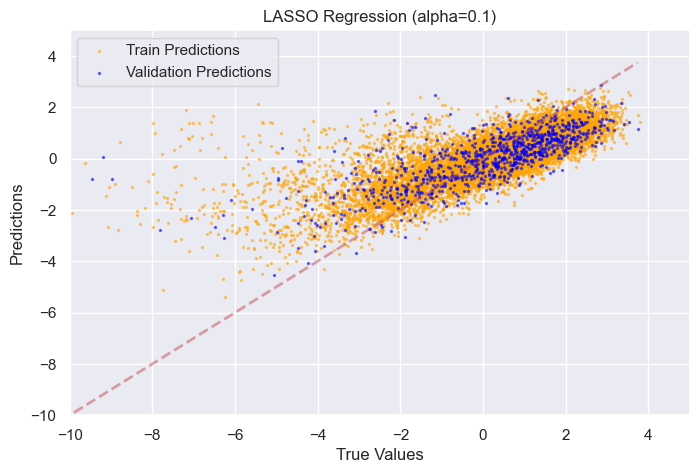

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Mean Squared Error: 1.4764186145244
R^2 Score: 0.6251560529191305
Mean Absolute Error: 0.7159686291439243


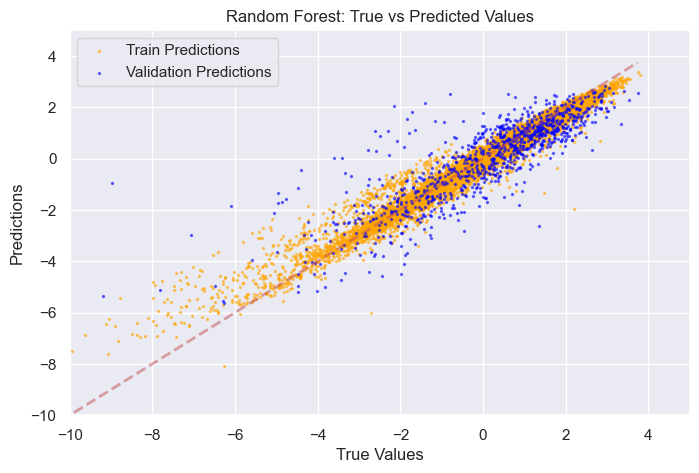

Mean Squared Error: 1.486249566078186
R^2 Score: 0.6226601004600525
Mean Absolute Error: 0.6832398772239685


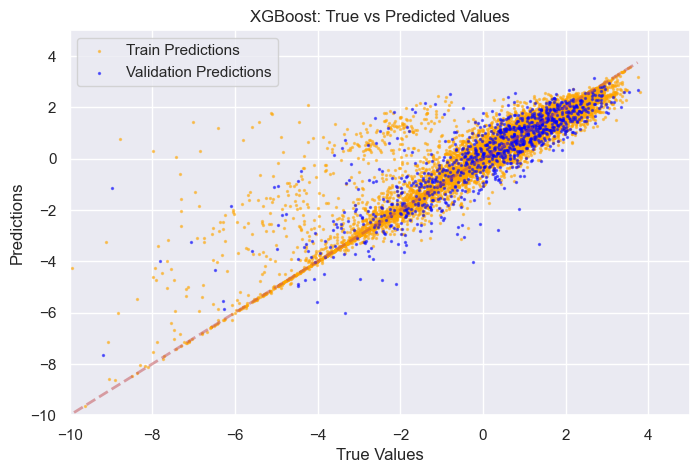

Mean Squared Error: 1.7527537308345513
R^2 Score: 0.554998074215973
Mean Absolute Error: 0.746189111654844


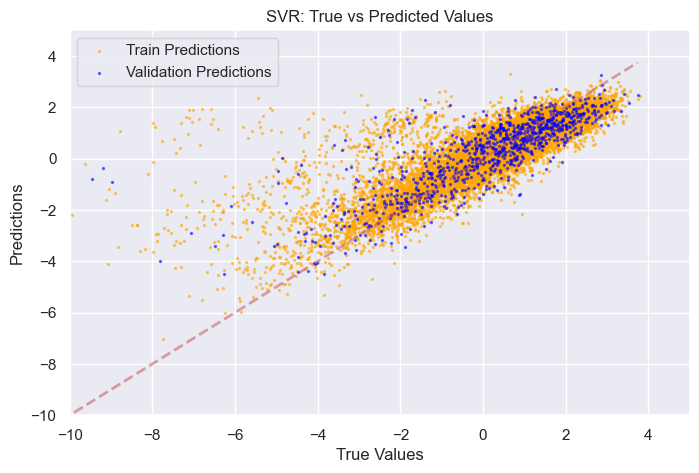

RWPE BON - RF MAE: 0.7159686291439243, XGB MAE: 0.6832398772239685, SVR MAE: 0.746189111654844


{'#Feats': 16,
 'LASSO': 0.952313451648016,
 'RF': 0.7159686291439243,
 'XGB': 0.6832398772239685,
 'SVR': 0.746189111654844}

In [352]:
#Random Walw + BON
random_walk_pe_bon_train = torch.cat((random_walk_pe_master_train, top5_principal_components), dim=1)
random_walk_pe_bon_val = torch.cat((random_walk_pe_master_val, top5_principal_components_val), dim=1)

completeEvaluations(
    'RWPE BON',
    EVALUATIONS,
    random_walk_pe_bon_train,
    trainDataset_rw.y.numpy(),
    random_walk_pe_bon_val,
    valDataset_rw.y.numpy()
)

## Laplacian Eigs

In [390]:
laplacianEigsTransform = T.AddLaplacianEigenvectorPE(k=8, attr_name='laplacian_eigs')
trainDataset_le = ZINC_Dataset.SMALL_TRAIN.load(transform=laplacianEigsTransform)
valDataset_le = ZINC_Dataset.SMALL_VAL.load(transform=laplacianEigsTransform)
trainDataset_le[0].x.shape, trainDataset_le[0].edge_attr.shape, trainDataset_le[0].laplacian_eigs.shape

(torch.Size([29, 1]), torch.Size([64]), torch.Size([29, 8]))

In [375]:
trainDataset_le[2].laplacian_eigs[-1].shape

torch.Size([5])

In [391]:
laplacianEigs_train = [g.laplacian_eigs[-1] for g in trainDataset_le]
laplacianEigs_val = [g.laplacian_eigs[-1] for g in valDataset_le]
laplacianEigs_train = torch.stack(laplacianEigs_train)
laplacianEigs_val = torch.stack(laplacianEigs_val)
laplacianEigs_train.shape, laplacianEigs_val.shape

(torch.Size([10000, 8]), torch.Size([1000, 8]))

Evaluating Laplacian Eigenvalues...
LASSO Regression (alpha=0.1):
Train MSE: 4.0434, R2: 0.0000, MAE: 1.5109
Validation MSE: 3.9390, R2: -0.0001, MAE: 1.4785


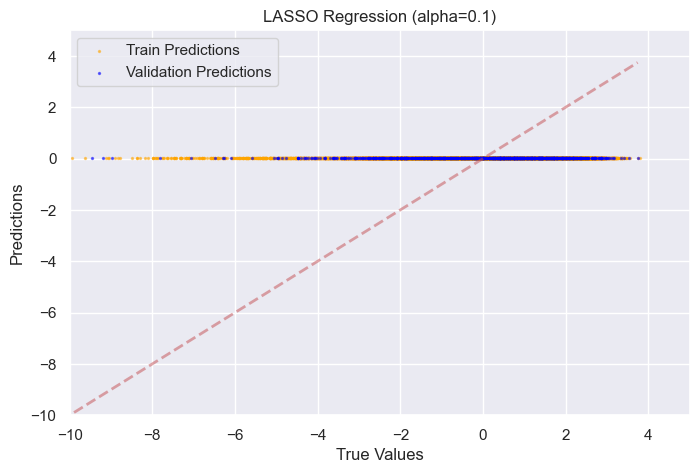

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   37.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   37.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent work

Mean Squared Error: 3.670579584466239
R^2 Score: 0.06808643159853367
Mean Absolute Error: 1.421852961662851


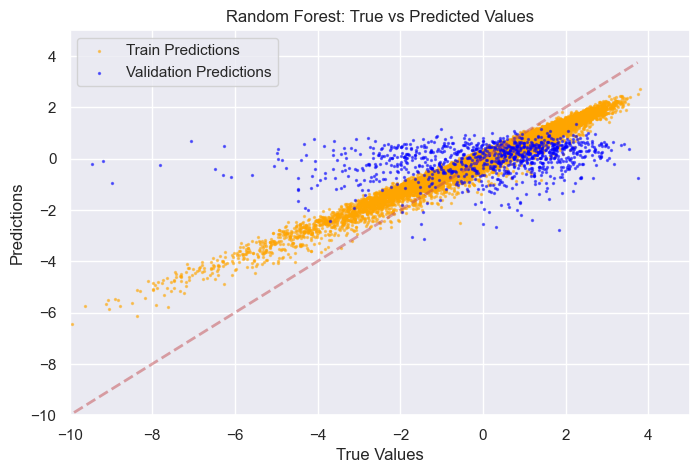

Mean Squared Error: 4.126898765563965
R^2 Score: -0.0477672815322876
Mean Absolute Error: 1.4701277017593384


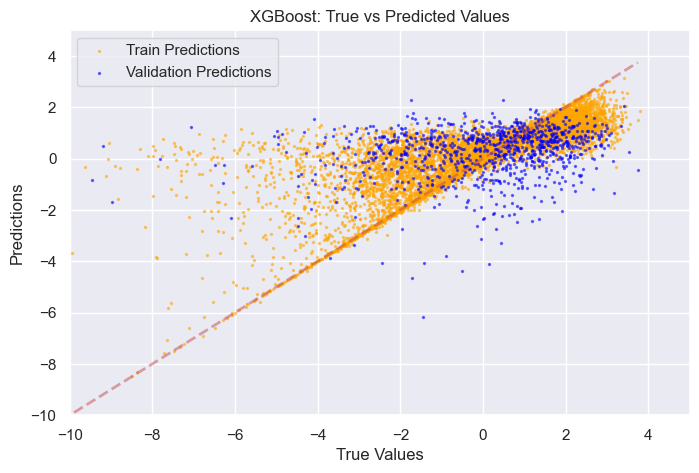

Mean Squared Error: 3.891823996615691
R^2 Score: 0.011915283454074443
Mean Absolute Error: 1.4094006111804964


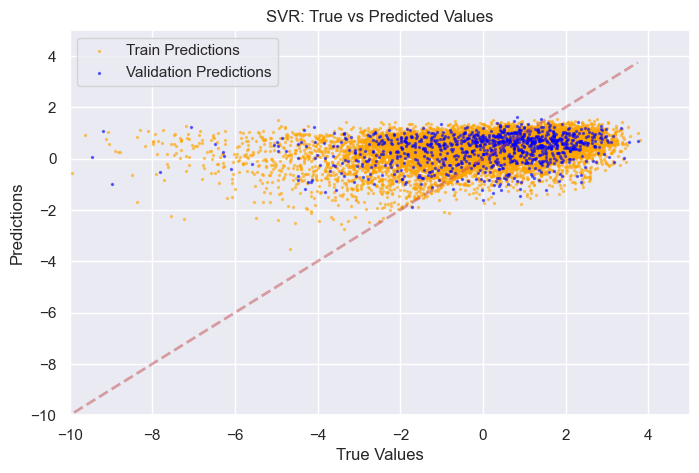

Laplacian Eigenvalues - RF MAE: 1.421852961662851, XGB MAE: 1.4701277017593384, SVR MAE: 1.4094006111804964


{'#Feats': 8,
 'LASSO': 1.4785104238663516,
 'RF': 1.421852961662851,
 'XGB': 1.4701277017593384,
 'SVR': 1.4094006111804964}

In [392]:
completeEvaluations(
    'Laplacian Eigenvalues',
    EVALUATIONS,
    laplacianEigs_train,
    trainDataset_le.y.numpy(),
    laplacianEigs_val,
    valDataset_le.y.numpy()
)

Evaluating BON + Laplacian Eigenvalues...
LASSO Regression (alpha=0.1):
Train MSE: 2.1609, R2: 0.4656, MAE: 0.9578
Validation MSE: 2.1692, R2: 0.4493, MAE: 0.9523


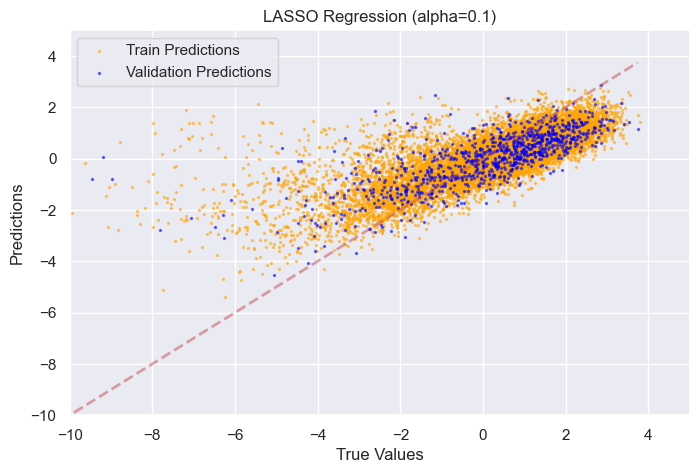

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Mean Squared Error: 1.5278136142878753
R^2 Score: 0.6121075147999012
Mean Absolute Error: 0.7184713990047117


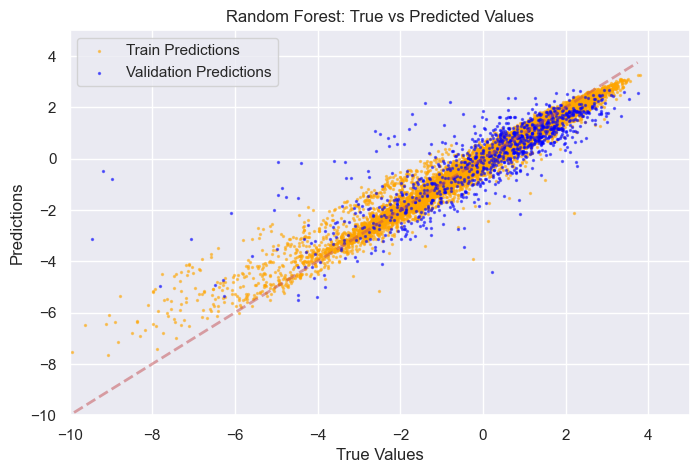

Mean Squared Error: 1.613004446029663
R^2 Score: 0.5904786586761475
Mean Absolute Error: 0.7077532410621643


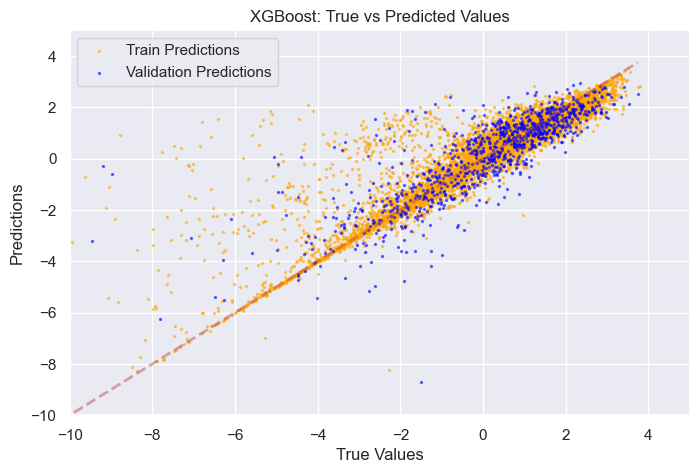

Mean Squared Error: 1.7529855265423384
R^2 Score: 0.5549392242277863
Mean Absolute Error: 0.7466457796717559


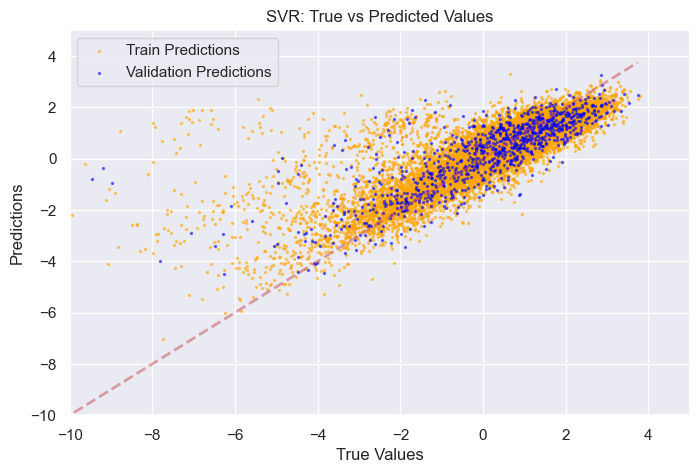

BON + Laplacian Eigenvalues - RF MAE: 0.7184713990047117, XGB MAE: 0.7077532410621643, SVR MAE: 0.7466457796717559


{'#Feats': 21,
 'LASSO': 0.952313451648016,
 'RF': 0.7184713990047117,
 'XGB': 0.7077532410621643,
 'SVR': 0.7466457796717559}

In [378]:
# Combine Laplacian eigenvalues with best BON features
bon_laplacian_train = torch.cat((top5_principal_components, laplacianEigs_train), dim=1)
bon_laplacian_val = torch.cat((top5_principal_components_val, laplacianEigs_val), dim=1)

completeEvaluations(
    'BON + Laplacian Eigenvalues',
    EVALUATIONS,
    bon_laplacian_train,
    trainDataset_bon.y.numpy(),
    bon_laplacian_val,
    valDataset_bon.y.numpy()
)

In [380]:
# Create comprehensive feature set with all best features
comprehensive_train = torch.cat((
    top5_principal_components,  # BON PCA top 5
    topBoe_train,              # BOE top features  
    bod_train,                 # BOD features
    laplacianEigs_train,       # Laplacian eigenvalues
    steady_state_train.unsqueeze(1)  # Steady state entropy
), dim=1)

comprehensive_val = torch.cat((
    top5_principal_components_val,
    topBoe_val,
    bod_val,
    laplacianEigs_val,
    steady_state_val.unsqueeze(1)
), dim=1)

comprehensive_train.shape, comprehensive_val.shape

(torch.Size([10000, 29]), torch.Size([1000, 29]))

Evaluating Comprehensive Features...
LASSO Regression (alpha=0.1):
Train MSE: 2.0388, R2: 0.4958, MAE: 0.9545
Validation MSE: 2.1306, R2: 0.4591, MAE: 0.9796


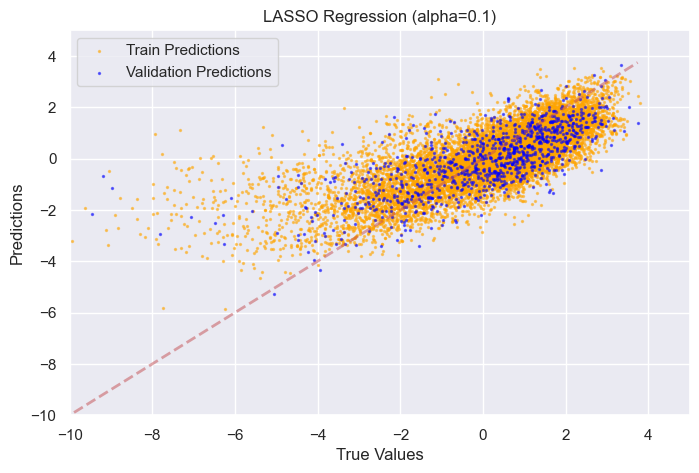

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Mean Squared Error: 1.473762929701726
R^2 Score: 0.625830297588861
Mean Absolute Error: 0.6765346052979601


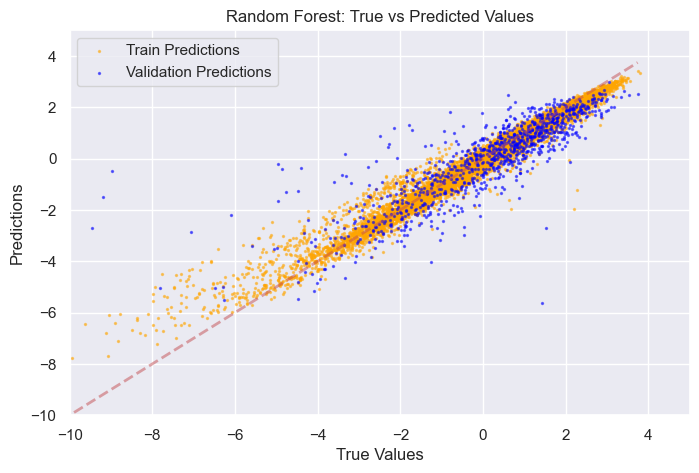

Mean Squared Error: 1.2901504039764404
R^2 Score: 0.6724472045898438
Mean Absolute Error: 0.6326426267623901


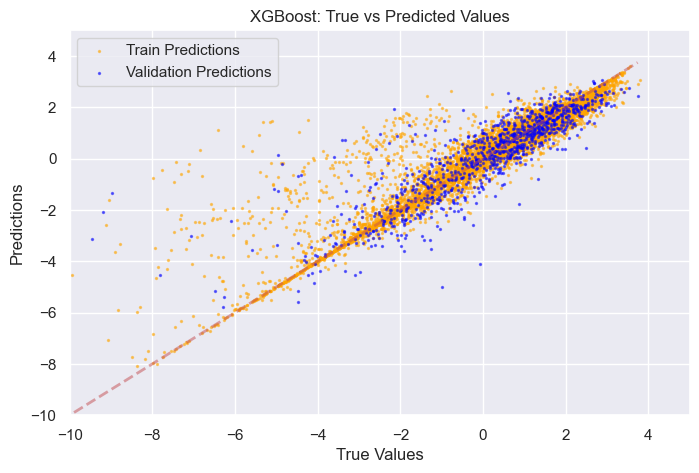

Mean Squared Error: 1.9711738164227068
R^2 Score: 0.4995439867382291
Mean Absolute Error: 0.8772156565422694


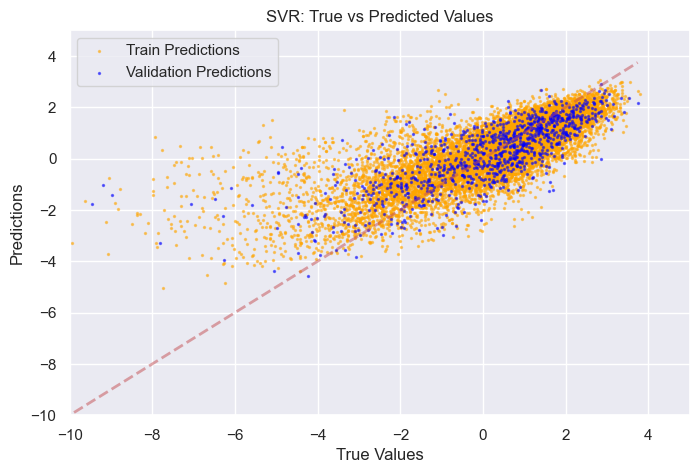

Comprehensive Features - RF MAE: 0.6765346052979601, XGB MAE: 0.6326426267623901, SVR MAE: 0.8772156565422694


{'#Feats': 29,
 'LASSO': 0.9796298098731027,
 'RF': 0.6765346052979601,
 'XGB': 0.6326426267623901,
 'SVR': 0.8772156565422694}

In [381]:
completeEvaluations(
    'Comprehensive Features',
    EVALUATIONS,
    comprehensive_train,
    trainDataset_bon.y.numpy(),
    comprehensive_val,
    valDataset_bon.y.numpy()
)

# Final Results

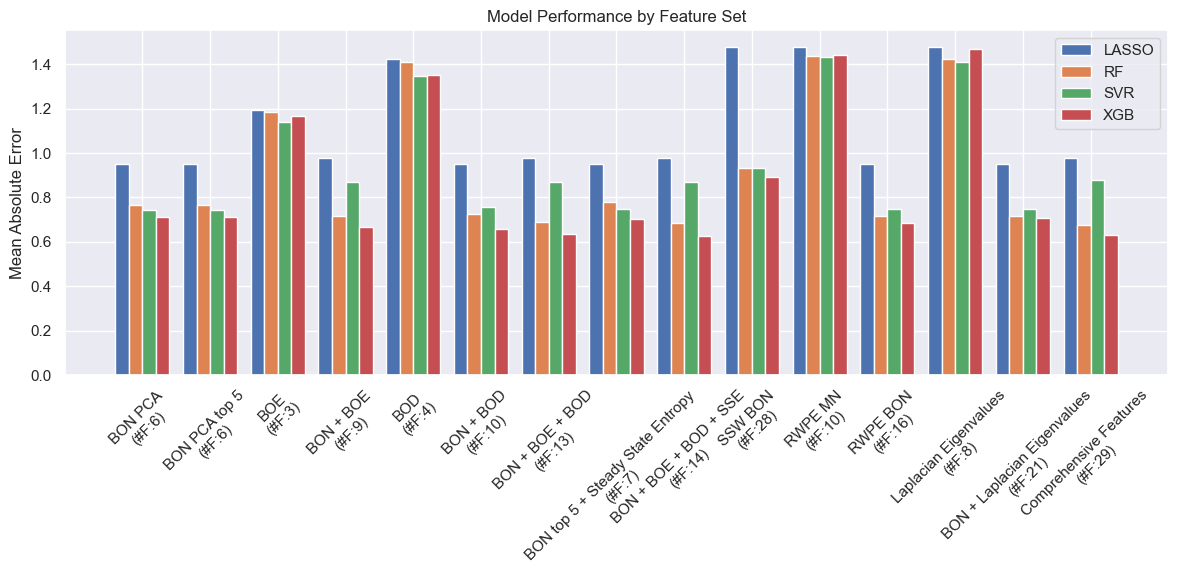

In [394]:
plotEvaluations(EVALUATIONS)